<h1 style="text-align:center">
Predição de casos de Dengue e risco de surto para o Estado de São Paulo em intervalo temporal:
</h1>


**Membros do grupo:**

● Vinicius Gustierrez Neves – 14749363 – viniciusgustierrez@gmail.com<br>
● Bruno Figueiredo Lima – 14562383 – bruno.lim4@usp.br<br>
● Thales Sena de Queiroz – 14608873 – thalessdq05@usp.br<br>
● Guilherme Pascoale Godoy – 14576277 – guilhermepascoale@usp.br<br>
● Gabriel Hyppolito – 14571810 – gabriel.hyppolito@usp.br


# Escolha do tema
A dengue é uma doença infecciosa que apresenta grande risco para a saúde pública, em especial em países tropicais como o Brasil, com o número de casos anuais podendo chegar aos milhões. Dessa forma, é imprescindível ter ferramentas que auxiliem na identificação de épocas e zonas de risco, para que os órgãos de saúde consigam se preparar e atender a população de forma eficiente.

Diante deste cenário, escolhemos como tema de nosso projeto aplicar técnicas de Aprendizado de Máquina para prever o número de casos de dengue em cidades do estado de São Paulo e para classificar o risco potencial da doença em cada município.

# Explicação geral do projeto

Construímos um **dataset semanal de município×tempo** para prever **casos de dengue na semana t+1** para **todos os 645 municípios de SP**, a partir de séries históricas do **SINAN/OpenDataSUS** integradas a clima em grade (**ERA5** e **CHIRPS**) e **população IBGE**, utilizando modelos de regressão e **mapas** de incidência prevista para a visualização dos resultados.

Fontes: **SINAN/OpenDataSUS** (casos), **ERA5 (single levels)** para temperatura a 2 m e ponto de orvalho (de onde derivamos **umidade relativa**) e **CHIRPS** (precipitação diária 0,05°).
Com **IBGE** (população e malha municipal), calculamos **incidência/100 mil** e geramos **mapa coroplético**.

**Pontos-chave**

* Trabalhamos com **casos prováveis** (descartados excluídos), agregados por **semana epidemiológica** do início dos sintomas.
* Clima é agregado **diário→semanal** e **espacialmente** por município (média zonal).
* **População** anual (estimativas IBGE) para normalização.
* Entregas: **dataset fixo** + **modelo de regressão (t+1)** + **modelo de classificação em 4 níveis** + **mapas coropléticos**.




> Este trabalho é resultado do projeto da disciplina de **Inteligência Artificial (USP São Carlos, 2025.2)**.

---

# Principais contribuições do projeto

**1) Dataset padronizado e reprodutível (município × SE)**

* Chaves harmonizadas com **código IBGE (7 dígitos)** e **semana epidemiológica (ISO)**.
* Integração de **casos (SINAN)**, **clima** (**ERA5: temperatura/UR; CHIRPS: chuva**) e **população IBGE**.
* Entrega em **Parquet**, pronto para treino, inferência e auditoria.

**2) Clima por município via estatística zonal (grade → polígono)**

* **ERA5 (single levels)**: `t2m` e `d2m` para derivar **umidade relativa**; agregação hora→dia→**semana**.
* **CHIRPS (0,05° diário)**: **soma semanal de chuva** e **dias com chuva**.
* Pipeline automatizado de download, recorte espacial e agregação temporal.

**3) Engenharia de atributos e alvo orientados à decisão**

* *Lags* de **casos e clima** (1–8 SE), **médias móveis** (2/4/8) e **sazonalidade** (senóides por semana do ano).
* Alvo **t+1** por município (`y_tplus1`) para previsão operacional.
* **Incidência/100 mil** via população IBGE (lookup multi-anos com *ffill/bfill*).

**4) Arquitetura clara: ETL → features → modelagem → entrega**

* Camadas `raw/interim/processed`, funções idempotentes e checagens de tipos.
* Suporte a validação temporal (**TimeSeriesSplit**) e comparação com **baseline** (ŷ_t+1 = y_t).
* Estrutura para persistir **pesos**, **lista de features** e **configuração** (reprodutibilidade).

**5) Produtos para vigilância epidemiológica**

* **Tabela de previsões por município** (casos e incidência previstas para t+1).
* **Mapa coroplético** estadual de **incidência prevista**, facilitando priorização territorial.


---
# Etapa de pré-processamento
## ETL — como os dados são obtidos e processados

**Casos (SINAN)**

* Baixa anos-alvo, filtra **prováveis** (`classi_fin != 2`), padroniza **código IBGE 7 dígitos**, deriva/usa **SE** do início dos sintomas e **agrega por município×SE**.

**Clima (grade)**

* **ERA5**: baixa `t2m` e `d2m` horários no **BBOX de SP**, converte p/ °C e calcula **UR**; agrega hora→dia→**semana** e faz **média espacial** por município.
A associação entre cidade e clima acontece por meio do geobr, que determina a geometria das cidades.
* **CHIRPS**: baixa GeoTIFFs **diários**, calcula **média por município**, agrega para **soma semanal (rain_sum_mm)** e **dias de chuva (rain_days)**.

**IBGE**

* **População** municipal por ano (estimativas): cria **lookup multi-ano** com *ffill/bfill* e faz **join** por **YEAR_ISO = SE//100**.
* **Malha municipal** (geometria): usada para estatística zonal e para o mapa.

---

## Formatos atuais dos dados

**Interim**

* `era5_semana_municipio.parquet` → `cod_mun:str(7)`, `SE:int`, `tmean_c:float`, `tdmean_c:float`, `rh_mean:float`.
* `chirps_semana_municipio.parquet` → `cod_mun`, `SE`, `rain_sum_mm:float`, `rain_days:int`.
* `sinan_weekly.parquet` (esperado) → `cod_mun`, `SE`, `casos_obs:int`.


**Processed**

* `dataset_municipio_semana.parquet` → `cod_mun`, `SE`, `YEAR_ISO`, `casos_obs`, clima, `pop`, `inc100k`.
* `dataset_municipio_semana_feats.parquet` → adiciona **lags**, **médias móveis**, **sazonalidade** e **`y_tplus1`**.

**Geodados**

* `ibge_municipios_sp_YYYY.gpkg` (opcional, cache) → geometrias para zonal e mapa.
  *Padrão* adequado (código IBGE 7 dígitos).

---

## Features, alvo e divisão temporal

**Alvo (regressão)**

* `y_tplus1 = casos_obs` da **próxima** semana (por município).
* Opcional: alvo em **incidência/100k** (`inc100k_tplus1`).

**Alvo (classificação)**
* criação de rótulos sobre o nível de risco de forma simplificada usando a regra:
- até 20 casos -> nível verde
- de 20 a 50 casos -> nível amarelo
- de 50 a 100 casos -> nível laranja
- mais de 100 casos -> nível vermelho

* classificação de risco de cada cidade para a semana **t+1**.

**Features**

* **Histórico**: `casos_obs_lag1..lag8`, `casos_obs_mm2/mm4/mm8`.
* **Clima** (se disponível): lags de `tmean_c`, `rh_mean`, `rain_sum_mm`, `rain_days`.
* **Sazonalidade**: `sin_w`, `cos_w`, `weekofyear`.
* **Controles**: `pop`, opcional `densidade_pop` (se incorporar área).

**Validação**

* **TimeSeriesSplit / walk-forward**, respeitando tempo (sem *leakage*).
* **Baseline**: `ŷ_{t+1} = y_t`.
* **Métricas**: **RMSE**, **MAE** (macro/micro; por município e agregadas).

---

# Extração de padrões

Para extrair conhecimento dos dados obtidos, usamos modelos de aprendizado de máquina para regressão e classificação. Tais modelos irão detectar padrões e usá-los para estimar valores futuros das variáveis-alvo.

# Treino e inferência

**Treino**

* Para a regressão, comparamos os modelos XGBoost e RandomForest, usados para prever o número de casos `y_tplus1`.
* Para a classificação, o modelo XGBoost Classifier foi escolhido para classificar as cidades em 4 níveis de alerta: verde, amarelo, laranja e vermelho. Os rótulos são definidos com base no número de casos registrados, e o treino leva em conta todos os atributos presentes no conjunto de dados.

**Inferência t→t+1**

* Montamos *features* usando dados até **t**, e usamos o modelo de regressão para predizer `y_tplus1` e de classificação para indicar o nível de risco nas cidades na semana **t+1**.

# Pós-processamento
Após a etapa de inferência, usamos os valores obtidos para construir mapas coropléticos, que utilizam cores sobre o mapa de São Paulo para indicar faixas de valores ou classes, dando uma pista visual do que o modelo conseguiu aprender.

**Mapa**

* Join com **malha IBGE** e plot **coroplético** de `inc100k_pred` para o resultado da classificação e `y_plus1` para o da regressão. O
resultado são mapas coloridos e visualmente bastante intuitivos, que nos mostram rapidamente a situação da dengue por todo o estado de SP.

# Utilização do conhecimento
Este projeto construiu ferramentas que nos auxiliam a entender como a dengue se distribui pelo estado de São Paulo. Esse conhecimento pode ser usado, por exemplo, por órgãos públicos para atender melhor os afetados pela doença, e também para o tratamento dos vetores, uma vez que os mapas plotados indicam a concentração de casos em regiões específicas do estado.

<!-- ##**Descrição do Projeto:**

Predição semanal de casos de dengue por município do Estado de São Paulo usando microdados do **SINAN** e clima de **INMET (estações)** ou **ERA5-Land/CHIRPS (grade)**; visualização em mapa com malha municipal do **IBGE**.

**Motivação:** Casos de dengue variam com fatores climáticos e sazonalidade; prever a **próxima semana epidemiológica (SE)** apoia ações de vigilância.
**O que entregamos:**

1. **Dataset fixo** (municipio × semana) para treino;
2. **Modelo de regressão** para prever **casos na semana t+1** por município;
3. **Mapa coroplético** (incidência/100k) por município de SP, usando a malha do IBGE.
   **Fontes oficiais:** SINAN/OpenDataSUS (atualização **semanal**), calendários SE oficiais; clima (INMET/BDMEP ou ERA5-Land + CHIRPS); população e malha municipal IBGE. ([Datasus][1])


## **Pipeline completo:**

## ETL – camadas e passos

**B.1 – Casos (SINAN/OpenDataSUS) → município×SE**

1. **Download** dos arquivos “Dengue – ano” (CSV/JSON) via página do dataset (2000–2025). O OpenDataSUS informa frequência **semanal** e notas: “casos prováveis = notificados exceto descartados”; investigações devem ser encerradas em até **60 dias** (logo, semanas recentes sofrem *backfill*). ([Datasus][1])
2. **Filtragem e padronização:**

   * **Data de início dos sintomas**: `dt_sin_pri` → derive **`sem_pri`** (semana epidemiológica do início dos sintomas; o campo já existe como variável interna no SINAN). ([Amazon Web Services, Inc.][2])
   * **Município de residência:** `id_mn_resi` (código IBGE). ([Amazon Web Services, Inc.][2])
   * **Classificação final:** `classi_fin` (1=**Confirmado**, 2=**Descartado**, 8=**Inconclusivo**). Para **“casos prováveis”**, siga a nota do dataset: **excluir descartados** (i.e., `classi_fin != 2`). ([Amazon Web Services, Inc.][2])
3. **Agregação**: conte `casos` por `[cod_mun_ibge, SE]` (use `sem_pri`); mantenha também “observados” e, se quiser, “prováveis” (≠2).
4. **Tratamento de atraso:** desconsidere as **últimas 2–3 SE** no treino ou aplique *nowcasting* depois (opcional). A nota oficial lembra encerramento em 60 dias. ([Datasus][1])

**B.2 – Clima**

* **Grade homogênea**:

  * **ERA5-Land** (horário): `t2m` (K) e `d2m` (K). Converter p/ °C e calcular **UR** a partir de T e ponto de orvalho; agregar **diário→SE**, e espacialmente como **média sobre o polígono do município**. ([Climate Data Store][4])
  * **CHIRPS** (diário, 0,05°): precipitação (mm/dia) → `rain_sum_week` (soma semanal) e `rain_days_week` (dias >1 mm). Observação operacional: CHIRPS tem *lag* típico de ~**45 dias** para “near-present”; ótimo para histórico/treino, mas, para previsão operacional imediata, prefira INMET para chuva recente. ([CRAN][5])

**B.3 – Demografia & Geodados (IBGE)**

* **População** (1º/07/2025) → `pop`: base para incidência/100k. ([IBGE][6])
* **Malha municipal** (shape): campo **`CD_MUN` (7 dígitos)**, geometria do município, `AREA_KM2`. Atenção: o SINAN usa códigos de 6 dígitos em alguns campos; padronize para o **código IBGE de 7 dígitos** (existe diferença de dígito verificador). ([IBGE][7])

**B.4 – Join e dataset “mestre” (fixo)**

* Chave de junção: `cod_mun_ibge_7d` + `SE` (AAAASE; calendário oficial). Use calendário SE do Portal Sinan (2025). ([SINANWEB][8])
* **Derivações úteis:** `inc100k = casos * 100000 / pop`; `season = mês(data_ini_SE)`; *lags* e médias móveis (ver features).

---

## Features, alvo e divisão temporal

**Alvo (regressão):** `y = casos_{t+1}` (ou incidência/100k na t+1), por município.
**Preditoras (exemplos):**

* Histórico: `casos_t`, `casos_t-1..t-8`, médias móveis (2, 4, 8 SE).
* Clima (agregado na SE):

  * Temperatura: `tmean`, `tmin`, `tmax` (°C) e *lags* (1–8 SE).
  * Umidade relativa média (`rh_mean`) e *lags*. (Se ERA5-Land: derivar de `t2m` e `d2m`). ([Climate Data Store][4])
  * Chuva: `rain_sum_week`, `rain_days_week` e *lags*. (Se CHIRPS, atenção ao *lag* de disponibilidade). ([CRAN][5])
* Sazonais: dummies de mês/SE, feriados (opcional).
* Controles: `densidade_pop = pop/AREA_KM2`.

**Particionamento/validação (time series):**

* **TimeSeriesSplit** / *walk-forward* por SE; *baseline* sazonal “ingênuo” (ŷ = y_t) como referência.
* Métricas: **RMSE, MAE** (e MAPE, se fizer sentido).

**Modelo (primeiro corte):**

* **XGBoost/LightGBM Regressor** (capturam não linearidades e interações lag-clima); ou **NegBin/Poisson** com *offset* log(pop) se preferir contagem.
* Treinar **modelo global** (todas as cidades com um único estimador) e usar `cod_mun` como categórica (target/one-hot), ou então modelos por cluster/região.

---

## Tabela “mestre” — colunas recomendadas (com origem)

**Identificação & tempo**

* `cod_mun_ibge_7d` (string, 7 dígitos) — **IBGE** (padronize mapeando de 6→7 dígitos quando vier do SINAN). ([IBGE][9])
* `nome_mun`, `uf` — **IBGE**. ([IBGE][7])
* `SE` (int, formato AAAASS) e `data_iniSE` (date) — **do SINAN (sem_pri)** ou do seu calendário SE oficial. ([Amazon Web Services, Inc.][2])

**Casos (SINAN/OpenDataSUS)**

* `casos_obs` (int) — contagem por município×SE a partir de **`dt_sin_pri`** e **`classi_fin`**; por padrão, use **“prováveis”** (≠ descartados). ([Amazon Web Services, Inc.][2])
* (opcional) `casos_conf` (int) — só **`classi_fin == 1`** (confirmados). ([Amazon Web Services, Inc.][2])

**Pop/Área (IBGE)**

* `pop` (int, 1º/07/2025) — **IBGE estimativas 2025**. ([IBGE][6])
* `area_km2` (float) — **IBGE malha**. ([IBGE][7])
* Derivadas: `inc100k = casos_obs * 1e5 / pop`, `densidade_pop = pop/area_km2`.

**Clima (uma rota ou combinação)**

*Se **INMET/BDMEP** (estações, diário→SE por média/soma):*

* `tmax_c`, `tmin_c`, `tmed_c` (°C) — médias semanais;
* `ur_mean` (%) — média semanal;
* `rain_sum_mm` (mm/semana), `rain_days` (dias >1 mm). ([BDMEP][3])

*Se **ERA5-Land + CHIRPS** (grade→município→SE):*

* `tmean_c`, `tmin_c`, `tmax_c` (°C) — de `t2m` (K → °C) e janelas semanais;
* `rh_mean` (%) — derivada de `t2m` & `d2m`;
* `rain_sum_mm` (mm/semana) e `rain_days` (dias >1 mm) — **CHIRPS**; notar *lag* de ~45 dias para dados “near-present”. ([Climate Data Store][4])

**Sazonais/auxiliares**

* `mes`, `ano`, `sem_do_ano` (ints), indicadores de feriado escolar (opcional).

> **Armazenamento:** salve a tabela “mestre” em **Parquet** (particionada por ano/SE) para reuso no Colab; isso é seu **dataset fixo** de treino/inferência.

---



---

# Organização do Colab (seções + artefatos)

1. **📄 Introdução (markdown)** — texto curto com objetivo, importância, entregáveis e fontes oficiais (SINAN/IBGE/INMET/ERA5/CHIRPS). ([Datasus][1])
2. **🔧 Config & paths** — seeds, UF=“SP”, ano inicial, janelas de *lags*; pastas `/content/data/raw|interim|processed|models|figures`.
3. **⬇️ Coleta – SINAN (OpenDataSUS)**

   * Download dos anos desejados; leitura incremental (chunks); seleção de colunas: `dt_sin_pri`, `sem_pri`, `id_mn_resi`, `classi_fin`.
   * Filtro de casos: **prováveis = classi_fin != 2**; agrega por `[cod_mun, SE]`. ([Amazon Web Services, Inc.][2])
4. **🌦️ Clima – rota INMET/BDMEP *ou* ERA5-Land+CHIRPS**

   * INMET: baixar diários, escolher estação por proximidade, agregar para SE. ([BDMEP][3])
   * ERA5-Land/CHIRPS: baixar *tiles*, clip por município (GeoPandas) e agregar por SE (nota sobre CHIRPS ~45 dias). ([Climate Data Store][4])
5. **🧭 IBGE – malha & população (join keys)**

   * Ler shapefile municipal (SP), garantir **7 dígitos**; harmonizar com código do SINAN (se vier 6 dígitos).
   * Ler **estimativas 2025** e unir por código IBGE. ([IBGE][7])
6. **🧹 Limpeza & dataset mestre**

   * Montar tabela final **municipio×SE** com todas as colunas listadas; gerar *lags* (1–8), médias móveis (2,4,8); remover últimas 2–3 SE de treino (atraso). ([Datasus][1])
   * Salvar **Parquet** (dataset fixo).
7. **🤖 Modelagem (regressão)**

   * Baseline sazonal; XGBoost/LightGBM; *TimeSeriesSplit*; métricas.
   * **Salvar pesos** + objetos de pré-processamento (`.joblib`) e **config.json**.
8. **🧪 Inferência**

   * Carregar pesos; construir *features* da semana t; prever **t+1**; calcular **incidência/100k**.
9. **🗺️ Mapa**

   * *Join* com malha; coroplético `inc100k_pred_{t+1}`; exportar PNG/HTML. ([IBGE][7])
10. **📦 Reprodutibilidade**

* `requirements.txt`, `random_state`, versão de dados (timestamp dos dumps do OpenDataSUS e ERA5/CHIRPS). -->

## **Existe relação direta entre dengue e clima? (o que a ciência mostra)**

**Temperatura**

* Regula o desenvolvimento do *Aedes*, a longevidade e a replicação viral.
* A transmissibilidade (R₀) é **não linear**, com pico típico entre **26–29 °C**; abaixo/acima disso o risco diminui.
  — Referência: [Mordecai et al., PLOS NTDs](https://journals.plos.org/plosntds/article?id=10.1371%2Fjournal.pntd.0005568)

**Chuva**

* Cria criadouros, mas o efeito é **defasado** (semanas) e **não monotônico**:
  muita chuva pode “lavar” criadouros; já estiagens estimulam armazenamento doméstico de água e elevam o risco **meses** depois.
* No Brasil, estiagem extrema elevou risco em **3–5 meses**; chuvas elevadas em **0–3 meses**.
  — Referência: [Lowe et al., *The Lancet Planetary Health*](https://www.thelancet.com/journals/lanplh/article/PIIS2542-5196%2820%2930292-8/fulltext)

**Umidade**

* Aumenta a sobrevivência do mosquito e atua como **moderador** junto da temperatura.
* Plataformas operacionais (ex.: **InfoDengue**) usam temperatura e umidade para ajustar a receptividade local.
  — Referência: [material de apoio – COSEMS/SP](https://www.cosemssp.org.br/wp-content/uploads/2025/05/CURSO10-Thais-Riback.pdf)

**Conclusão**
Há relação **física** e **estatisticamente demonstrável**, porém **não linear** e **não instantânea**: envolve defasagens (≈ **1–8 semanas**) e *trade-offs* climáticos. A previsão é útil operacionalmente (especialmente para **probabilidade de surto/alerta**), mas as magnitudes exatas também dependem de **sorotipos**, **imunidade**, **mobilidade** e **ações de controle**.


In [ ]:


!pip install pysus
!pip -q install geobr pyogrio
!pip -q install cdsapi xarray netCDF4 rioxarray rasterio rasterstats
!pip -q install duckdb
!pip -q install odfpy
!pip -1 install cdsapi>=0.7.7


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.10.0 requires tqdm>=4.65, but you have tqdm 4.64.0 which is incompatible.
spopt 0.7.0 requires tqdm>=4.66.0, but you have tqdm 4.64.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

Usage:   
  pip3 <command> [options]

no such option: -1


In [ ]:
#Criação do arquivo de configuração para acesso ao Eras5
%%bash
cat > ~/.cdsapirc << 'EOF'
url: https://cds.climate.copernicus.eu/api
key: cb57d853-3157-43c4-a58f-27ef86722be7
EOF

## **1) Extração e tratamento dos dados:**

###  Config & paths (com CV 5 folds ancorado nas semanas mais recentes)

In [ ]:
# Dados já estão no Drive; vamos montar a pasta para acessá-los
from google.colab import drive
import zipfile
import os

# Montar o Google Drive
drive.mount('/content/drive')

# Configurações de Caminho
  # Caminho do arquivo zip no Drive
caminho_zip_drive = '/content/drive/MyDrive/TrabalhoIA/Trabalho_Ia_semCHIRPS.zip'

# Onde vamos descompactar na máquina do Colab (rápido e temporário)
pasta_destino_colab = '/content/dados'

# Descompactar
print(f"Extraindo {caminho_zip_drive} para {pasta_destino_colab}...")

if not os.path.exists(caminho_zip_drive):
    print("ERRO: Arquivo não encontrado! Verifique o caminho para o arquivo em seu Drive.")
else:
    with zipfile.ZipFile(caminho_zip_drive, 'r') as zip_ref:
        zip_ref.extractall(pasta_destino_colab)
    print("Arquivos extraídos.")

Mounted at /content/drive
Extraindo /content/drive/MyDrive/TrabalhoIA/Trabalho_Ia_semCHIRPS.zip para /content/dados...
ERRO: Arquivo não encontrado! Verifique o caminho para o arquivo em seu Drive.


In [ ]:
import os, re
from pathlib import Path
import pandas as pd, numpy as np
from pysus.ftp.databases.sinan import SINAN
import duckdb

import os
from pathlib import Path
import pandas as pd

try:
    from pysus import SINAN
except Exception as e:
    raise RuntimeError("PySUS não está instalado ou não pôde ser importado. "
                        "Instale 'pysus' e reexecute.") from e

try:
    from geobr import read_municipality
except Exception as e:
    raise RuntimeError("geobr (Python) não está instalado. Instale 'geobr' e reexecute.") from e


SEED = 42
np.random.seed(SEED)
UF_SIGLA = "SP"
UF_IBGE  = 35
ANOS_SINAN = list(range(2024, 2026))

# Janelas e CV
JANELAS_LAGS = [1,2,3,4,5,6,7,8]
JANELAS_MM   = [2,4,8]
N_TEST_WEEKS = 3
N_VAL_FOLDS  = 5
BACKFILL_CUTOFF = 3

# Pastas
BASE = Path('/content/dados/Trabalho_Ia') ##### Definir caminho de vocês aqui
DIRS = {
    "raw": BASE/"data"/"raw",
    "interim": BASE/"data"/"interim",
    "processed": BASE/"data"/"processed",
    "models": BASE/"models",
    "figures": BASE/"figures",
    "splits": BASE/"data"/"splits",
}
for d in DIRS.values():
    d.mkdir(parents=True, exist_ok=True)

PATH_SINAN_WEEKLY = DIRS["interim"]/"sinan_weekly.parquet"

# Cache do PySUS
os.environ.setdefault("PYSUS_CACHEPATH", str(BASE/".pysus"))



'/content/dados/Trabalho_Ia/.pysus'

In [ ]:
import os
from pathlib import Path
import pandas as pd
import duckdb

# (Opcional / fallback) DV módulo 10 — mantém aqui só como plano B
def calcula_dv_ibge_mod10(cod_mun_6: str) -> str | None:
    if not isinstance(cod_mun_6, str):
        return None
    s = cod_mun_6.strip()
    if len(s) != 6 or not s.isdigit():
        return None
    soma, pesos = 0, [1,2,1,2,1,2]
    for i in range(6):
        produto = int(s[i]) * pesos[i]
        soma += (produto // 10) + (produto % 10)
    dv = 0 if (soma % 10) == 0 else (10 - (soma % 10))
    return s + str(dv)

def _build_exprs_from_schema(cols_present: list[str]) -> dict:
    name_map = {c.upper(): c for c in cols_present}
    has = lambda c: c.upper() in name_map
    col = lambda c: name_map[c.upper()]

    uf_txt_cands = [c for c in ["SG_UF_NOT","SG_UF_RES","SG_UF","UF"] if has(c)]
    uf_num_cands = [c for c in ["SG_UF_NOT","SG_UF_RES"] if has(c)]
    mun_cands    = [c for c in ["ID_MUNICIP","ID_MN_RESI","CO_MUN_RES","ID_MUNICIP_RES"] if has(c)]
    sem_cands    = [c for c in ["SEM_PRI","SEM_NOT"] if has(c)]
    dt_cands     = [c for c in ["DT_SIN_PRI","DT_NOTIFIC"] if has(c)]
    classi_cands = [c for c in ["CLASSI_FIN"] if has(c)]

    def up_varchar(cs):  return "NULL" if not cs else f"COALESCE({', '.join([f'UPPER(CAST({col(c)} AS VARCHAR))' for c in cs])})"
    def try_int(cs):     return "NULL" if not cs else f"COALESCE({', '.join([f'TRY_CAST({col(c)} AS INTEGER)' for c in cs])})"
    def as_varchar(cs):  return "NULL" if not cs else f"COALESCE({', '.join([f'CAST({col(c)} AS VARCHAR)' for c in cs])})"
    def try_date(cs):    return "NULL" if not cs else f"COALESCE({', '.join([f'TRY_CAST({col(c)} AS DATE)' for c in cs])})"

    uf_txt_expr = up_varchar(uf_txt_cands)
    uf_num_expr = try_int(uf_num_cands)
    mun_expr    = as_varchar(mun_cands)
    sem_expr    = try_int(sem_cands)
    dt_expr     = try_date(dt_cands)
    class_expr  = try_int(classi_cands)

    cod_mun6_expr = f"LPAD({mun_expr}, 6, '0')"                     # agregue em 6 dígitos
    se_expr       = f"COALESCE({sem_expr}, YEARWEEK({dt_expr}))"     # ISO YYYYWW (DuckDB)

    uf_filter = f"(COALESCE({uf_txt_expr}, '') = '{UF_SIGLA}' OR {uf_num_expr} = {UF_IBGE})"
    descartado_filter = f"COALESCE({class_expr}, 999999) <> 2"
    guards = f"{mun_expr} IS NOT NULL AND ({sem_expr} IS NOT NULL OR {dt_expr} IS NOT NULL)"

    return {
        "cod_mun6_expr": cod_mun6_expr,
        "se_expr": se_expr,
        "uf_filter": uf_filter,
        "descartado_filter": descartado_filter,
        "nonnull_guards": guards,
    }

def _agg_year_with_duckdb(parquet_dir: Path) -> pd.DataFrame:
    # aceita diretório ou arquivo .parquet
    glob_path = str(parquet_dir / "*.parquet") if parquet_dir.is_dir() else str(parquet_dir)
    con = duckdb.connect(str(BASE/"workspace.duckdb"))
    con.execute("PRAGMA threads=4")

    schema = con.execute(
        f"DESCRIBE SELECT * FROM read_parquet('{glob_path}', union_by_name=true) LIMIT 0"
    ).df()
    cols = schema["column_name"].tolist()
    exprs = _build_exprs_from_schema(cols)

    print(f"   • DuckDB: {BASE/'workspace.duckdb'}")
    print(f"   • Lendo:  {glob_path}")
    print(f"   • Colunas vistas: {', '.join(cols[:10])}{' …' if len(cols)>10 else ''}")

    sql = f"""
    SELECT
      {exprs['cod_mun6_expr']} AS cod_mun_6,
      CAST({exprs['se_expr']} AS BIGINT) AS SE,
      COUNT(*) AS casos_obs
    FROM read_parquet('{glob_path}', union_by_name=true)
    WHERE {exprs['uf_filter']}
      AND {exprs['descartado_filter']}
      AND {exprs['nonnull_guards']}
    GROUP BY 1,2
    """
    out = con.execute(sql).df()
    con.close()
    return out

def build_sinan_weekly_if_missing_pysus_duckdb(force: bool=False):
    # evita reaproveitar arquivo antigo se force=True
    if (not force) and PATH_SINAN_WEEKLY.exists() and PATH_SINAN_WEEKLY.stat().st_size > 0:
        print("SINAN semanal já existe:", PATH_SINAN_WEEKLY, "(use force=True para reconstruir)")
        return

    # PySUS
    try:
        from pysus import SINAN
    except Exception as e:
        raise RuntimeError("PySUS não disponível. Instale/importe 'pysus'.") from e

    print("Iniciando coleta do SINAN via PySUS…")
    sinan = SINAN().load()
    files = sinan.get_files(dis_code="DENG", year=ANOS_SINAN)
    print(f" {len(files)} arquivos encontrados para DENG nos anos {ANOS_SINAN}")

    pecas = []
    for f in files:
        print(f"\n Baixando: {f}")
        pq = f.download(local_dir=str(DIRS["raw"]))
        p = Path(str(pq))
        try:
            print("Conteúdo:", os.listdir(str(p))[:5])
        except Exception:
            pass

        g = _agg_year_with_duckdb(p)

        # robustez: garantir colunas e dtypes
        if "cod_mun_6" not in g.columns:
            if "cod_mun" in g.columns:
                s = g["cod_mun"].astype(str)
                g["cod_mun_6"] = s.str.zfill(7).str[:6]
                g = g.drop(columns=["cod_mun"])
            else:
                raise ValueError("Agregado não possui 'cod_mun_6' nem 'cod_mun'. Atualize o helper.")

        g["cod_mun_6"] = g["cod_mun_6"].astype(str).str.zfill(6)
        g["SE"] = g["SE"].astype(int)
        g["casos_obs"] = g["casos_obs"].astype(int)

        print(f" Agregado (ano): {len(g):,} linhas | munis={g['cod_mun_6'].nunique()} | SE={g['SE'].nunique()}")
        pecas.append(g)

    if not pecas:
        raise RuntimeError("Nenhum arquivo do SINAN foi agregado. Verifique anos/código da doença.")

    sinan_weekly_6 = (
        pd.concat(pecas, ignore_index=True)
          .groupby(["cod_mun_6","SE"], as_index=False)["casos_obs"].sum()
    )

    # ---- Mapa 6→7 preferencial (geobr) ----
    try:
        from geobr import read_municipality
        gdf_sp = read_municipality(code_muni="SP", year=2020)[["code_muni"]]

        # >>> FIX 1: garanta que code_muni é inteiro (não float) antes de virar string
        gdf_sp["code_muni"] = pd.to_numeric(gdf_sp["code_muni"], errors="raise").astype("int64")  # :contentReference[oaicite:0]{index=0}

        lut = (
            gdf_sp.rename(columns={"code_muni":"cod_mun"})
                  .assign(
                      cod_mun=lambda d: d["cod_mun"].astype("int64").astype(str).str.zfill(7),
                      cod_mun_6=lambda d: d["cod_mun"].astype("int64").astype(str).str.zfill(7).str[:6],
                  )[["cod_mun_6","cod_mun"]]
                  .drop_duplicates()
        )

        sinan_weekly = sinan_weekly_6.merge(lut, on="cod_mun_6", how="left")
        missing = sinan_weekly["cod_mun"].isna().sum()
        if missing > 0:
            exemplos = (sinan_weekly.loc[sinan_weekly["cod_mun"].isna(), "cod_mun_6"]
                                    .value_counts().head(5).index.tolist())
            raise RuntimeError(
                f"Falha no mapeamento 6→7 para {missing} linhas. Exemplos: {exemplos}. "
                "Cheque filtro de UF e malha/ano do geobr."
            )
    except Exception as ge:
        print(" Aviso: geobr indisponível. Usando fallback de DV (módulo 10).")
        sinan_weekly_6 = sinan_weekly_6.copy()
        sinan_weekly_6["cod_mun"] = sinan_weekly_6["cod_mun_6"].astype(str).str.zfill(6).map(calcula_dv_ibge_mod10)
        if sinan_weekly_6["cod_mun"].isna().any():
            raise RuntimeError("Fallback por DV falhou para alguns códigos de 6 dígitos.")
        sinan_weekly = sinan_weekly_6.drop(columns=["cod_mun_6"])

    # ---- Dtypes, limpeza e salvar ----
    sinan_weekly = (
        sinan_weekly
          .assign(
              cod_mun=lambda d: (d["cod_mun"].astype(str)
                                               .str.replace(r"\.0$", "", regex=True)
                                               .str.replace(r"\D", "", regex=True)
                                               .str.zfill(7)),                         # :contentReference[oaicite:1]{index=1}
              SE=lambda d: d["SE"].astype("int64"),
              casos_obs=lambda d: d["casos_obs"].astype("int64"),
          )
          .astype({"cod_mun":"string"})                                                # :contentReference[oaicite:2]{index=2}
          .sort_values(["cod_mun","SE"], kind="stable")
          .reset_index(drop=True)
    )

    PATH_SINAN_WEEKLY.parent.mkdir(parents=True, exist_ok=True)
    sinan_weekly.to_parquet(PATH_SINAN_WEEKLY, index=False)

    print("\n SINAN semanal gerado!")
    print(f"{PATH_SINAN_WEEKLY} | linhas={len(sinan_weekly):,} | "
          f"municípios={sinan_weekly['cod_mun'].nunique()} | SE únicas={sinan_weekly['SE'].nunique()}")
    return sinan_weekly

# 1ª execução após corrigir: force=True para reprocessar
build_sinan_weekly_if_missing_pysus_duckdb(force=True)


RuntimeError: PySUS não disponível. Instale/importe 'pysus'.

In [ ]:
# -*- coding: utf-8 -*-
import re, numpy as np, pandas as pd
from pathlib import Path

# caminhos já definidos no seu notebook:
# PATH_SINAN_WEEKLY, DIRS

def se_to_year_week(se: pd.Series):
    se = se.astype(int)
    return se // 100, se % 100

def se_to_monday_date(se: pd.Series):
    # Constrói a segunda-feira ISO da semana AAAAWW
    # %G = ano ISO, %V = semana ISO, %u = dia (1=segunda)
    return pd.to_datetime(se.astype(str) + "1", format="%G%V%u", errors="coerce")

# 1) Carrega parquet recém-gerado
sinan = pd.read_parquet(PATH_SINAN_WEEKLY).copy()

print("=== SINAN semanal (preview) ===")
print(sinan.head())
print("\nshape:", sinan.shape)

# 2) Checagens estruturais de chaves e tipos
assert {"cod_mun","SE","casos_obs"}.issubset(sinan.columns), "Faltam colunas essenciais no SINAN"
sinan["cod_mun"] = (sinan["cod_mun"].astype(str)
                                   .str.replace(r"\.0$", "", regex=True)
                                   .str.replace(r"\D", "", regex=True)
                                   .str.zfill(7))
sinan["SE"]       = sinan["SE"].astype(int)
sinan["casos_obs"]= sinan["casos_obs"].astype(int)

# (a) formato IBGE-7 e UF=35
ok_7dig   = sinan["cod_mun"].str.fullmatch(r"\d{7}").all()
ok_sp35   = sinan["cod_mun"].str.startswith("35").all()  # SP=35 (código IBGE da UF)
print(f"\nCódigos 7 dígitos? {ok_7dig} | Começam com 35? {ok_sp35}")
assert ok_7dig and ok_sp35, "cod_mun não está como IBGE-7 de SP (35xxxxx)."

# (b) (cod_mun, SE) sem duplicatas
dups = sinan.duplicated(["cod_mun","SE"]).sum()
print("Duplicatas (cod_mun,SE):", dups)
assert dups == 0, "Existem chaves duplicadas (cod_mun, SE)."

# (c) SE válido (semana 1..53)
year_iso, week_iso = se_to_year_week(sinan["SE"])
bad_week = ~week_iso.between(1,53)
print("SE inválidas (semana fora de 1..53):", int(bad_week.sum()))
assert bad_week.sum() == 0, "Há semanas fora do intervalo 1..53."

# (d) Data ISO coerente com SE (não NaT)
monday = se_to_monday_date(sinan["SE"])
print("Datas ISO NaT? ", float(monday.isna().mean()))
assert monday.notna().all(), "Falha ao materializar data ISO a partir de SE (formato AAAAWW)."

# 3) Cobertura de municípios vs. referência (geobr) e estatísticas básicas
#    Obs.: nem todo município precisa ter casos em todos os anos,
#    mas todos os cod_mun devem existir na malha de SP.
# --- Validação contra geobr (corrigida) ---
try:
    from geobr import read_municipality

    gdf_sp = read_municipality(code_muni="SP", year=2020)[["code_muni"]]

    # Coerção robusta: int64 -> str -> zfill(7)
    gdf_sp["code_muni"] = pd.to_numeric(gdf_sp["code_muni"], errors="coerce").astype("Int64")
    geobr_codes = set(
        gdf_sp["code_muni"].dropna().astype("int64").astype(str).str.zfill(7).tolist()
    )

    # Normaliza os códigos do SINAN da mesma forma
    sinan_codes = set(
        sinan["cod_mun"].astype(str)
                        .str.replace(r"\.0$", "", regex=True)
                        .str.replace(r"\D", "", regex=True)
                        .str.zfill(7)
                        .tolist()
    )

    # Checagens
    print(f"Municípios no geobr: {len(geobr_codes)} (esperado ~645)")
    anti = sinan_codes - geobr_codes
    print("Códigos no SINAN que NÃO estão no geobr (amostra):", list(sorted(anti))[:10],
          ("… " + str(len(anti)) + " total") if len(anti) > 10 else "")
    assert len(anti) == 0, "Há códigos no SINAN que não existem na malha geobr de SP."

except Exception as e:
    print("Aviso: não consegui validar contra geobr (ok seguir). Erro:", repr(e))


# 4) Sinais sanitários: valores e distribuição
neg = (sinan["casos_obs"] < 0).sum()
print("\nCasos negativos? ", int(neg))
assert neg == 0, "Existem casos_obs negativos (não deveria)."

by_year = (sinan.assign(YEAR_ISO=sinan["SE"]//100)
                 .groupby("YEAR_ISO", as_index=False)["casos_obs"].sum())
print("\nCasos por ano (amostra):")
print(by_year.head())

# 5) (Opcional) Contiguidade de semanas por município - diagnóstico (sem assert)
#    Atenção: semanas sem casos não aparecem na série agregada (é normal existirem “gaps”).
print("\nExemplo de contiguidade (3 municípios aleatórios):")
for cod in np.random.RandomState(42).choice(sinan["cod_mun"].unique(), size=min(3, sinan['cod_mun'].nunique()), replace=False):
    s = sinan.loc[sinan["cod_mun"]==cod, "SE"].sort_values()
    dates = se_to_monday_date(s)
    diffs = dates.diff().dt.days.dropna()
    gaps  = (diffs > 7).sum()
    print(f"- {cod}: linhas={len(s)} | gaps>7d={int(gaps)} (normal se houver semanas sem casos)")

print("\n Checagens do SINAN concluídas.")


=== SINAN semanal (preview) ===
  cod_mun_6      SE  casos_obs  cod_mun
0    350010  202401          2  3500105
1    350010  202402          1  3500105
2    350010  202403          1  3500105
3    350010  202404          5  3500105
4    350010  202405          5  3500105

shape: (38864, 4)

Códigos 7 dígitos? True | Começam com 35? True
Duplicatas (cod_mun,SE): 0
SE inválidas (semana fora de 1..53): 0
Datas ISO NaT?  0.0
Municípios no geobr: 645 (esperado ~645)
Códigos no SINAN que NÃO estão no geobr (amostra): [] 

Casos negativos?  0

Casos por ano (amostra):
   YEAR_ISO  casos_obs
0      2024    2182413
1      2025     898371

Exemplo de contiguidade (3 municípios aleatórios):
- 3556404: linhas=86 | gaps>7d=9 (normal se houver semanas sem casos)
- 3553203: linhas=63 | gaps>7d=15 (normal se houver semanas sem casos)
- 3553807: linhas=46 | gaps>7d=10 (normal se houver semanas sem casos)

✅ Checagens do SINAN concluídas.


## IBGE – malha & população
 - Malha municipal 2024 via geobr (IBGE) → filtra UF=SP
 - População municipal 2025 (01/07/2025) → join por cod IBGE 7 dígitos
 Fontes: Malhas 2024/IBGE e Estimativas 2025/IBGE.  (ver referências)

In [ ]:
import pandas as pd, numpy as np, requests, re, unicodedata
from geobr import read_municipality
from pathlib import Path

# --- Configuração ---
# Simula a variável DIRS que você mencionou

UF = "SP"  # sua UF
RAW = DIRS["raw"]

# --- Funções Auxiliares ---

def _strip_acc(s: str) -> str:
    """Normaliza e remove acentos de uma string."""
    return unicodedata.normalize("NFKD", str(s)).encode("ascii","ignore").decode().lower()

def _try_read_table(path: Path):
    """Tenta ler arquivo Excel (ODS ou XLSX) e retorna dicionário de abas."""
    # tenta ODS; se der erro, tenta XLSX
    try:
        # Tenta ODS
        return pd.read_excel(path, engine="odf", sheet_name=None)
    except Exception:
        # Tenta XLSX (openpyxl/xlrd conforme extensão)
        return pd.read_excel(path, sheet_name=None)

def _find_columns(df: pd.DataFrame):
    """Tenta encontrar as colunas de município e população em um DataFrame (LÓGICA GENÉRICA)."""
    cols_norm = {c: _strip_acc(c) for c in df.columns}
    mun_col = pop_col = None

    # tentativa 1: nomes explícitos (procura coluna com código completo)

    mun_keys = ["codigo do municipio", "cod municipio", "codmun", "codigo ibge", "cod geocmu"]
    pop_keys = ["populacao", "habitantes", "estimativa", "1° de julho", "1o de julho", "populacao estimada"]

    for c, cn in cols_norm.items():
        if any(k in cn for k in mun_keys):
            mun_col = c
            break

    for c, cn in cols_norm.items():
        if any(k in cn for k in pop_keys):
            # Verifica se a coluna é majoritariamente numérica
            if pd.to_numeric(df[c], errors="coerce").notna().sum() > 100:
                pop_col = c
                break

    # tentativa 2: se ainda não achou muni (padrão NNNNNNN - Nome (UF))
    if mun_col is None:
        for c in df.columns:
            if df[c].astype(str).str.match(r"\d{6,7}\s*-\s*.+\(.+\)").sum() > 100:
                mun_col = c
                break

    # tentativa 3: se pop_col não achou (melhor coluna numérica)
    if pop_col is None:
        best = None
        best_cnt = 0
        for c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce")
            cnt = (s > 5000).sum() # Heurística: mais de 100 municípios com > 5000 hab.
            if cnt > best_cnt:
                best, best_cnt = c, cnt
        if best_cnt > 100:
            pop_col = best

    return mun_col, pop_col



def processa_pop_ibge(ano: int):
    """Baixa, processa e filtra dados de população do IBGE para um ano e UF."""


    urls = [
        # 1. Singular (Padrão de 2024, 2025)
        f"https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_{ano}/estimativa_dou_{ano}.ods",
        f"https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_{ano}/estimativa_dou_{ano}.xlsx",
        # 2. Plural (Padrão que às vezes usam)
        f"https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_{ano}/estimativas_dou_{ano}.ods",
        f"https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_{ano}/estimativas_dou_{ano}.xlsx",
        # 3. Padrão específico de 2023 (com sufixo _tcm e data)
        f"https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_{ano}/estimativas_dou_{ano}_tcm_20240417.xlsx",
    ]
    path_local = None
    for u in urls:
        try:
            r = requests.get(u, timeout=180)
            if r.status_code == 200 and r.content:
                path_local = RAW / Path(u).name
                with open(path_local, "wb") as f: f.write(r.content)
                print(f"   OK: {u.split('/')[-1]}")
                break
            else:
                print(f"   {u.split('/')[-1]} não disponível (HTTP {r.status_code})")
        except Exception as e:
            print(f"   Falha ao baixar {u.split('/')[-1]}: {e}")
    if path_local is None:
        raise RuntimeError(f"Não conseguiu baixar ODS/XLSX de {ano}")

    sheets = _try_read_table(path_local)
    print("   Abas encontradas:", list(sheets.keys()))

    mun_col = pop_col = None
    df_ok = None
    # percorre abas até encontrar uma combinação válida
    for sh, df in sheets.items():
        df = df.dropna(how="all")
        # remove colunas totalmente vazias
        df = df.loc[:, df.notna().any(axis=0)]
        if df.empty or df.shape[1] < 2:
            continue

        if not df.empty:
            try:
                # Pega a primeira linha de dados (que o pandas leu)
                first_row_values = [str(v) for v in df.iloc[0]]
                df_row0_norm = [_strip_acc(c) for c in first_row_values]

                # Palavras-chave
                mun_keys = ["codigo do municipio", "cod municipio", "codmun", "codigo ibge", "cod geocmu", "cod. munic"] # "cod. munic" é a chave aqui
                pop_keys = ["populacao", "habitantes", "estimativa", "1° de julho", "1o de julho", "populacao estimada"]

                has_cod_in_row0 = any(k in col for col in df_row0_norm for k in mun_keys)
                has_pop_in_row0 = any(k in col for col in df_row0_norm for k in pop_keys)

                # Se a linha 0 (iloc[0]) parece ser um cabeçalho, promove-a
                if has_cod_in_row0 and has_pop_in_row0:
                    print(f"   Aba '{sh}': Cabeçalho real detectado na linha 1 do Excel. Promovendo...")
                    df.columns = df.iloc[0]
                    df = df.iloc[1:].reset_index(drop=True)
                    df = df.dropna(how="all")
            except Exception as e:
                print(f"   Aba '{sh}': Aviso ao tentar promover cabeçalho: {e}")

        if df.empty: continue

        cols_norm = {c: _strip_acc(c) for c in df.columns}
        uf_col, mun_part_col, pop_col_2024 = None, None, None

        pop_keys_check = ["populacao", "habitantes", "estimativa", "1° de julho", "1o de julho", "populacao estimada"]

        for c, cn in cols_norm.items():
            if "cod. uf" in cn:
                uf_col = c
            if "cod. munic" in cn:
                mun_part_col = c
            if any(k in cn for k in pop_keys_check):
                if pd.to_numeric(df[c], errors="coerce").notna().sum() > 100:
                    pop_col_2024 = c

        if uf_col and mun_part_col and pop_col_2024:
            print(f"   Aba '{sh}': Detectada lógica de colunas separadas (tipo 2023/2024).")
            try:
                df_temp = df[[uf_col, mun_part_col, pop_col_2024]].dropna(how="any").copy()
                df_temp.columns = ["uf_raw", "mun_part_raw", "pop"]

                df_ok = pd.DataFrame()
                df_ok["cod_mun"] = (
                    df_temp["uf_raw"].astype(str).str.strip() +
                    df_temp["mun_part_raw"].astype(str).str.strip().str.zfill(5) # Cód municipal tem 5 dígitos
                )
                df_ok["pop"] = df_temp["pop"]
                print(f"   Código construído (amostra): {df_ok['cod_mun'].iloc[0]}")
                break
            except Exception as e:
                print(f"   Falha ao tentar construir código 2024: {e}")
                df_ok = None

        # Se a lógica específica falhou ou não se aplica, usa a lógica genérica
        if df_ok is None:
            mcol, pcol = _find_columns(df) # _find_columns agora deve procurar o cod completo
            print(f"   Aba '{sh}': Lógica genérica. mun_col='{mcol}', pop_col='{pcol}'")
            if mcol and pcol:
                df_ok = df[[mcol, pcol]].copy()
                df_ok.columns = ["mun_raw", "pop"]
                # A extração de 'cod_mun' de 'mun_raw' acontecerá *depois* do loop
                break

    if df_ok is None:
        # A tentativa de fallback (regex) permanece, caso a lógica acima falhe
        pass # Omitindo por brevidade, a primeira correção deve bastar.

    if df_ok is None:
        raise ValueError(f"Não encontrei colunas de município/população em {ano}")

    # extrai cod IBGE (se necessário, ou seja, se usou a lógica genérica)
    if "cod_mun" not in df_ok.columns:
        print("   Extraindo 'cod_mun' da coluna 'mun_raw' (lógica genérica)...")
        # extrai cod IBGE
        df_ok["cod_mun"] = (
            df_ok["mun_raw"].astype(str)
            .str.extract(r"(\b\d{7}\b)")[0]  # Procura um número de EXATAMENTE 7 dígitos
        )

        # Se isso falhar, tenta a sua regex original (6 ou 7 dígitos)
        if df_ok["cod_mun"].isna().any():
            print("   Aviso: Extração de 7 dígitos falhou, tentando 6-7 dígitos.")
            df_ok["cod_mun"] = (
                df_ok["mun_raw"].astype(str)
                .str.extract(r"(\d{6,7})")[0]
            )

        df_ok["cod_mun"] = df_ok["cod_mun"].astype(str).str.strip().str.zfill(7)

    # Limpa e formata a população
    df_ok["pop"] = (pd.to_numeric(df_ok["pop"], errors="coerce")
                    .astype("float64"))

    df_ok = df_ok.dropna(subset=["cod_mun", "pop"])

    # filtra SP pela malha geobr
    print(f"Carregando malha municipal (geobr) para filtrar {UF}...")
    gdf = read_municipality(year=2024, simplified=True) # Usar um ano recente é OK


    sp_codes = (
        gdf[gdf["abbrev_state"] == UF]["code_muni"]
        .astype(float) # Garante que é numérico
        .astype(int)   # Converte para inteiro (remove o .0)
        .astype(str)   # Converte para string
        .str.zfill(7)  # Garante 7 dígitos
    )

    out = df_ok[df_ok["cod_mun"].isin(sp_codes)][["cod_mun","pop"]].dropna()
    out = out.groupby("cod_mun", as_index=False).agg(pop=("pop","max"))  # se houver duplicatas

    if out.empty:
        print(f" Atenção: Nenhum município de {UF} encontrado nos dados de {ano}.")
        print(f"   Códigos extraídos (amostra): {df_ok['cod_mun'].unique()[:10]}")
        print(f"   Códigos {UF} (geobr - amostra): {sp_codes.unique()[:10]}")
    else:
        out_path = RAW / f"ibge_pop_{ano}_{UF.lower()}.parquet"
        out.to_parquet(out_path, index=False)
        print(f" População {UF} {ano} salva: {out_path} | linhas={len(out)}")
        # debug rápido
        print(out.head())


for ano in [2024, 2025]:
    try:
        processa_pop_ibge(ano)
    except Exception as e:
        print(f" Falhou {ano}: {e}")


⬇️ Baixando estimativas 2024…
   • OK: estimativa_dou_2024.ods
📖 Lendo arquivo (todas as abas)…
   • Abas encontradas: ['BRASIL_E_UFs', 'MUNICÍPIOS']
   • Aba 'BRASIL_E_UFs': Lógica genérica. mun_col='None', pop_col='None'
   • Aba 'MUNICÍPIOS': Cabeçalho real detectado na linha 1 do Excel. Promovendo...
   • Aba 'MUNICÍPIOS': Detectada lógica de colunas separadas (tipo 2023/2024).
   • Código construído (amostra): 1100015
🗺️ Carregando malha municipal (geobr) para filtrar SP...
✅ População SP 2024 salva: /content/dados/Trabalho_Ia/data/raw/ibge_pop_2024_sp.parquet | linhas=645
   cod_mun      pop
0  3500105  35642.0
1  3500204   4478.0
2  3500303  32888.0
3  3500402   7470.0
4  3500501  18245.0

⬇️ Baixando estimativas 2025…
   • OK: estimativa_dou_2025.ods
📖 Lendo arquivo (todas as abas)…
   • Abas encontradas: ['BRASIL_E_UFs', 'Municípios']
   • Aba 'BRASIL_E_UFs': Lógica genérica. mun_col='None', pop_col='None'
   • Aba 'Municípios': Cabeçalho real detectado na linha 1 do Excel. P

##  Clima – ERA5-Land + CHIRPS (sem INMET)
 ERA5-Land (CDS): t2m (K) e d2m (K) → °C → UR(%) derivada de T & Td; agrega hora→dia→SE.  
 CHIRPS: precipitação diária 0,05° → soma semanal e nº de dias com chuva (>1 mm).  
 Fontes: ERA5-Land (CDS/ECMWF) e CHIRPS (CHC/UCSB).  (ver referências)  

### Configurar a chave da API do ERA5 (CDS)

Crie o arquivo:

```bash
nano ~/.cdsapirc
```

Cole:

```
url: https://cds.climate.copernicus.eu/api
key: cb57d853-3157-43c4-a58f-27ef86722be7
verify: 1
```

Salvar com:

* **CTRL+O**
* **ENTER**
* **CTRL+X**

In [ ]:
import cdsapi
c = cdsapi.Client()

In [ ]:
# -*- coding: utf-8 -*-
# ===== Rebuild ERA5 semanal com all_touched=True e checagens de cobertura =====

import pandas as pd, numpy as np, geopandas as gpd, xarray as xr
import rioxarray
from rasterstats import zonal_stats
from calendar import monthrange
from pathlib import Path

# ---- caminhos/constantes
PATH_MASTER = Path(DIRS["processed"]) / "dataset_municipio_semana.parquet"
PATH_ERA5   = Path(DIRS["interim"])   / "era5_semana_municipio.parquet"
RAW_ERA5    = Path(DIRS["raw"])       / "era5"  # onde ficam os .nc por mês/variável
GPKG_PATH   = Path(DIRS["raw"])       / "ibge_municipios_sp_2020.gpkg"

ERA5_DATASET = "reanalysis-era5-single-levels"
ERA5_VARS = ["2m_temperature","2m_dewpoint_temperature"]  # t2m (K), d2m (K)
BBOX_SP   = [ -19.5, -53.5, -25.5, -44.0 ]  # [N, W, S, E]
ERA_YEARS = range(2024, 2026)
ERA5_LATENCY_DAYS = 6

# ---- helpers
def _norm_cod(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    m8 = s.notna() & (s >= 10_000_000) & ((s % 10) == 0)  # ex.: 35169030 -> 3516903
    s.loc[m8] = (s.loc[m8] / 10).round()
    return s.astype("Int64").astype(str).str.zfill(7)

def ensure_gpkg_sp(year=2020):
    if GPKG_PATH.exists():
        gdf = gpd.read_file(GPKG_PATH).to_crs(4326)
        # normaliza SEMPRE, mesmo se já existir
        if "cod_mun" not in gdf:
            for c in ("code_muni","cd_mun","CD_MUN"):
                if c in gdf: gdf = gdf.rename(columns={c:"cod_mun"}); break
        gdf["cod_mun"] = _norm_cod(gdf["cod_mun"])
    else:
        from geobr import read_municipality
        muni = read_municipality(code_muni="SP", year=year, simplified=False)
        gdf = gpd.GeoDataFrame(muni).to_crs(4326)
        gdf = gdf.rename(columns={"code_muni":"cod_mun"})
        gdf["cod_mun"] = _norm_cod(gdf["cod_mun"])
        GPKG_PATH.parent.mkdir(parents=True, exist_ok=True)
        gdf.to_file(GPKG_PATH, driver="GPKG")
    assert len(gdf) >= 640, f"GPKG inesperado: {len(gdf)} feições."
    return gdf[["cod_mun","geometry"]].copy()

def k2c(da): return da - 273.15

def rel_humidity_from_t_td(t_c, td_c):
    es = 6.1094 * np.exp(17.625 * t_c  / (t_c  + 243.04))
    e  = 6.1094 * np.exp(17.625 * td_c / (td_c + 243.04))
    return np.clip((e/es)*100, 0, 100)

def iso_yearweek_from_date(dates):
    iso = pd.to_datetime(dates).dt.isocalendar()
    return (iso["year"].astype("int64")*100 + iso["week"].astype("int64")).astype("int64")

def _era5_latest_ts(latency_days=ERA5_LATENCY_DAYS):
    return pd.Timestamp.utcnow().floor('H') - pd.Timedelta(days=latency_days)

def open_era5_da(nc_path, prefer_var=None, fallbacks=None):
    ds = xr.open_dataset(nc_path, decode_times=True)
    if "expver" in ds.dims:
        try: ds = ds.sel(expver=ds["expver"].max())
        except Exception: ds = ds.mean("expver")
    # escolhe var
    if prefer_var and prefer_var in ds.data_vars:
        var = prefer_var
    elif fallbacks:
        var = next((v for v in fallbacks if v in ds.data_vars), list(ds.data_vars)[0])
    else:
        var = list(ds.data_vars)[0]
    da = ds[var]
    if "longitude" in da.dims: da = da.rename({"longitude":"lon"})
    if "latitude"  in da.dims: da = da.rename({"latitude":"lat"})
    # normaliza coord temporal
    tcoord = next((c for c in da.coords if np.issubdtype(da[c].dtype, np.datetime64)), None)
    if tcoord and tcoord != "time": da = da.rename({tcoord:"time"})
    return da

def cds_download_era5_month(year, month, variable, dest_nc, *, latency_days=ERA5_LATENCY_DAYS):
    from cdsapi import Client
    dest_nc = Path(dest_nc)
    if dest_nc.exists() and dest_nc.stat().st_size > 0:
        return dest_nc
    latest = _era5_latest_ts(latency_days)
    if (year, month) > (latest.year, latest.month):
        print(f" {variable} {year}-{month:02d}: mês ainda indisponível.")
        return None
    last_day = monthrange(year, month)[1]
    if year == latest.year and month == latest.month:
        last_day = int(latest.day)
    days = [f"{d:02d}" for d in range(1, last_day+1)]
    req = dict(
        format="netcdf",
        product_type="reanalysis",
        variable=[variable],
        year=f"{year}", month=f"{month:02d}", day=days,
        time=[f"{h:02d}:00" for h in range(24)],
        area=BBOX_SP,  # [North, West, South, East]
        # opcional: grid=["0.1/0.1"],  # reamostrar na origem (ajuda polígonos bem pequenos)
    )
    dest_nc.parent.mkdir(parents=True, exist_ok=True)
    Client().retrieve(ERA5_DATASET, req, str(dest_nc))
    return dest_nc

# ---- ETL ERA5 com all_touched=True
def build_era5_week_all_touched(years, geobr_year=2020, *, coverage_min=0.0):
    gdf_sp = ensure_gpkg_sp(year=geobr_year)
    n_muni = len(gdf_sp)
    print(f"[GPKG] municípios: {n_muni} (esperado 645)")

    registros = []
    RAW_ERA5.mkdir(parents=True, exist_ok=True)

    for y in years:
        for m in range(1, 13):
            fl = {}
            for var in ERA5_VARS:
                f = RAW_ERA5 / f"{var}_{y}{m:02d}.nc"
                got = cds_download_era5_month(y, m, var, f, latency_days=ERA5_LATENCY_DAYS)
                fl[var] = f if got else None
            if not fl.get("2m_temperature") or not fl.get("2m_dewpoint_temperature"):
                continue

            t_da = open_era5_da(fl["2m_temperature"], prefer_var="t2m", fallbacks=["2m_temperature"])
            d_da = open_era5_da(fl["2m_dewpoint_temperature"], prefer_var="d2m", fallbacks=["2m_dewpoint_temperature"])

            # hora → diário (°C)
            t_day = k2c(t_da).resample(time="1D").mean()
            d_day = k2c(d_da).resample(time="1D").mean()

            # define CRS e dims espaciais uma única vez
            for nm, da in (("tmean_c", t_day), ("tdmean_c", d_day)):
                da.rio.set_spatial_dims("lon","lat", inplace=True)
                da.rio.write_crs("EPSG:4326", inplace=True)

            # processa dia a dia (usando GeoTIFF temporário) com all_touched=True
            for t in pd.to_datetime(t_day.time.values):
                tif_t = Path(DIRS["interim"]) / f"_tmp_tmean_{str(pd.to_datetime(t).date())}.tif"
                tif_d = Path(DIRS["interim"]) / f"_tmp_tdmean_{str(pd.to_datetime(t).date())}.tif"
                t_day.sel(time=t).rio.to_raster(tif_t, compress="LZW")
                d_day.sel(time=t).rio.to_raster(tif_d, compress="LZW")

                zs_t = zonal_stats(gdf_sp, tif_t, stats=["mean"], nodata=np.nan, all_touched=True)
                zs_d = zonal_stats(gdf_sp, tif_d, stats=["mean"], nodata=np.nan, all_touched=True)

                # sanity: tamanho precisa bater
                if not (len(zs_t) == len(zs_d) == n_muni):
                    raise RuntimeError(f"zonal_stats retornou tamanho inesperado em {t.date()}: {len(zs_t)} vs {n_muni}")

                out = pd.DataFrame({
                    "cod_mun": gdf_sp["cod_mun"].to_numpy(),  # já está como 7 dígitos
                    "date": pd.to_datetime(t),
                    "tmean_c": [z["mean"] for z in zs_t],
                    "tdmean_c": [z["mean"] for z in zs_d],
                })
                registros.append(out)

                # limpa temporários
                try: tif_t.unlink(); tif_d.unlink()
                except: pass

    df = pd.concat(registros, ignore_index=True) if registros else pd.DataFrame()
    if df.empty:
        raise RuntimeError("ERA5: nenhum registro produzido.")

    # RH e SE semanal (usa só dias existentes)
    df["rh_mean"] = rel_humidity_from_t_td(df["tmean_c"], df["tdmean_c"])
    df["SE"] = iso_yearweek_from_date(df["date"])

    weekly = (df.groupby(["cod_mun","SE"], as_index=False)
                .agg(tmean_c=("tmean_c","mean"),
                     tdmean_c=("tdmean_c","mean"),
                     rh_mean =("rh_mean","mean"),
                     n_days  =("date","count")))
    weekly["coverage"] = weekly["n_days"] / 7.0


    if coverage_min > 0:
        weekly.loc[weekly["coverage"] < coverage_min, ["tmean_c","tdmean_c","rh_mean"]] = np.nan

    weekly["YEAR_ISO"] = (weekly["SE"] // 100).astype(int)
    weekly = weekly.drop_duplicates(["cod_mun","SE"])

    weekly.to_parquet(PATH_ERA5, index=False)
    print("ERA5 semanal salvo:", PATH_ERA5, "| linhas:", len(weekly))
    return weekly

# PARTE COMENTADA PORQUE JÁ TENHO OS ARQUIVOS E DEMORA PRA RODAR
# SE NÃO TIVER, RODE ESSA PARTE TAMBÉM

# ---- EXECUÇÃO: apaga parquet antigo e reconstrói
#if PATH_ERA5.exists():
#    try:
#        PATH_ERA5.unlink()
#        print(" ERA5 antigo removido:", PATH_ERA5)
#    except Exception as e:
#        print("Aviso ao apagar ERA5:", e)

# era5_week = build_era5_week_all_touched(ERA_YEARS, geobr_year=2020, coverage_min=0.0)

# ---- PÓS: validação rápida contra o MASTER
master = pd.read_parquet(PATH_MASTER)[["cod_mun","SE"]].copy()
master["cod_mun"] = _norm_cod(master["cod_mun"])
era5   = pd.read_parquet(PATH_ERA5)[["cod_mun","SE"]].copy()
era5["cod_mun"] = _norm_cod(era5["cod_mun"])

print(f"[MASTER] municípios únicos: {master['cod_mun'].nunique()}")
print(f"[ERA5  ] municípios únicos: {era5['cod_mun'].nunique()} (esperado ~645)")
mrg = master.merge(era5.assign(flag=1), on=["cod_mun","SE"], how="left")
print("[Cobertura ERA5 no MASTER] =", float(mrg["flag"].fillna(0).mean()))


In [ ]:
# -*- coding: utf-8 -*-
# ==== DIAGNÓSTICO PROFUNDO DO DESENCONTRO ERA5 x MASTER ====

import pandas as pd, numpy as np
from pathlib import Path

def find_first_existing(cands):
    for p in cands:
        p = Path(p)
        if p.exists():
            return p
    return None

def normalize_keys(df: pd.DataFrame) -> pd.DataFrame:
    # padroniza cod_mun e SE
    if 'cod_mun' not in df.columns:
        for c in ('code_muni','cd_mun','CD_MUN','cod_mun_7','cod_mun_6'):
            if c in df.columns:
                df.rename(columns={c:'cod_mun'}, inplace=True); break
    # para evitar “35169030”
    df['cod_mun'] = pd.to_numeric(df['cod_mun'], errors='coerce')
    mask8z = df['cod_mun'].notna() & (df['cod_mun'] >= 10_000_000) & (df['cod_mun'] % 10 == 0)
    df.loc[mask8z, 'cod_mun'] = (df.loc[mask8z, 'cod_mun'] / 10).round()
    df['cod_mun'] = df['cod_mun'].astype('Int64').astype(str).str.zfill(7)

    if 'SE' not in df.columns:
        ycol = next((c for c in df.columns if c.lower() in ('year_iso','ano_iso','year')), None)
        wcol = next((c for c in df.columns if c.lower() in ('week_iso','semana_iso','week','wk')), None)
        assert ycol and wcol, "Precisa de SE ou (YEAR/WEEK)."
        df['SE'] = (df[ycol].astype(int)*100 + df[wcol].astype(int)).astype(int)
    df['SE'] = df['SE'].astype(int)
    return df

# ---- paths ----
CAND_MASTER = []
CAND_ERA5   = []
if 'DIRS' in globals():
    CAND_MASTER += [Path(DIRS['processed']) / 'dataset_municipio_semana.parquet']
    CAND_ERA5   += [Path(DIRS['interim'])   / 'era5_semana_municipio.parquet']
# fallbacks
CAND_MASTER += [Path('/home/ax-vinicius-neves/Área de trabalho/Trabalho_Ia/data/processed/dataset_municipio_semana.parquet')]
CAND_ERA5   += [Path('/home/ax-vinicius-neves/Área de trabalho/Trabalho_Ia/data/interim/era5_semana_municipio.parquet')]

PATH_MASTER = find_first_existing(CAND_MASTER)
PATH_ERA5   = find_first_existing(CAND_ERA5)
assert PATH_MASTER and PATH_ERA5, "Ajuste os caminhos do MASTER/ERA5."

print(f"[OK] ERA5:   {PATH_ERA5}")
print(f"[OK] MASTER: {PATH_MASTER}")

master = normalize_keys(pd.read_parquet(PATH_MASTER))[['cod_mun','SE']]
era5   = normalize_keys(pd.read_parquet(PATH_ERA5))  [['cod_mun','SE','tmean_c','tdmean_c','rh_mean']]

# -------- 1) Cobertura global (reconfirma) --------
mrg = master.merge(era5, on=['cod_mun','SE'], how='left')
cov = {c: float(mrg[c].notna().mean()) for c in ['tmean_c','tdmean_c','rh_mean']}
print("\n[Cobertura global após merge ERA5]", cov)

# -------- 2) Quantos municípios existem em cada base? --------
mun_master = master['cod_mun'].nunique()
mun_era5   = era5['cod_mun'].nunique()
mun_int    = len(set(master['cod_mun']).intersection(set(era5['cod_mun'])))
print(f"\n[Municípios únicos] MASTER={mun_master} | ERA5={mun_era5} | INTERSEÇÃO={mun_int}")

# Liste 10 municípios que existem no MASTER e não existem no ERA5 (e vice-versa)
only_mun_master = sorted(list(set(master['cod_mun']) - set(era5['cod_mun'])))[:10]
only_mun_era5   = sorted(list(set(era5['cod_mun'])   - set(master['cod_mun'])))[:10]
print(f"Exemplo municípios só no MASTER (10): {only_mun_master}")
print(f"Exemplo municípios só no ERA5   (10): {only_mun_era5}")

# -------- 3) Quantas semanas (SE) existem em cada base? --------
se_master = master['SE'].nunique()
se_era5   = era5['SE'].nunique()
se_int    = len(set(master['SE']).intersection(set(era5['SE'])))
print(f"\n[SE únicas] MASTER={se_master} | ERA5={se_era5} | INTERSEÇÃO={se_int}")

# Liste 10 SEs presentes só em um lado
only_se_master = sorted(list(set(master['SE']) - set(era5['SE'])))[:10]
only_se_era5   = sorted(list(set(era5['SE'])   - set(master['SE'])))[:10]
print(f"Exemplo SE só no MASTER (10): {only_se_master}")
print(f"Exemplo SE só no ERA5   (10): {only_se_era5}")

# -------- 4) Cobertura por município (que fração das SE do MASTER casam no ERA5?) --------
# cria flag de presença
era5_flag = era5.copy()
era5_flag['flag'] = 1
pres = master.merge(era5_flag[['cod_mun','SE','flag']], on=['cod_mun','SE'], how='left')
mun_cov = pres.groupby('cod_mun')['flag'].mean().fillna(0.0)

print("\n[Resumo cobertura por município] (proporção de SE do MASTER que casam no ERA5)")
print(mun_cov.describe(percentiles=[0.0,0.1,0.25,0.5,0.75,0.9,1.0]))

# Top 10 municípios com pior cobertura (0.0 → nunca casa)
bad_munis = mun_cov.sort_values().head(10)
print("\nPiores municípios (10):")
print(bad_munis)

# -------- 5) Cobertura por SE (que fração dos municípios do MASTER casam no ERA5?) --------
se_cov = pres.groupby('SE')['flag'].mean().fillna(0.0)
print("\n[Resumo cobertura por SE] (proporção de municípios do MASTER que casam no ERA5)")
print(se_cov.describe(percentiles=[0.0,0.1,0.25,0.5,0.75,0.9,1.0]))

# Top 10 piores semanas
bad_weeks = se_cov.sort_values().head(10)
print("\nPiores SE (10):")
print(bad_weeks)

# -------- 6) Validação da chave: existem cod_mun inválidos no ERA5? (não 7 dígitos numéricos) --------
def invalid_cod_mun(s: pd.Series):
    # invalido se não bater ^\d{7}$
    return ~s.astype(str).str.fullmatch(r"\d{7}")

invalid_era5 = era5[ invalid_cod_mun(era5['cod_mun']) ]['cod_mun'].unique().tolist()
invalid_master = master[ invalid_cod_mun(master['cod_mun']) ]['cod_mun'].unique().tolist()

print("\n[cod_mun inválidos] ERA5:", invalid_era5[:10], ("(mais...)" if len(invalid_era5)>10 else ""))
print("[cod_mun inválidos] MASTER:", invalid_master[:10], ("(mais...)" if len(invalid_master)>10 else ""))

print("\n Diagnóstico profundo concluído.")


[OK] ERA5:   /content/dados/Trabalho_Ia/data/interim/era5_semana_municipio.parquet
[OK] MASTER: /content/dados/Trabalho_Ia/data/processed/dataset_municipio_semana.parquet

[Cobertura global após merge ERA5] {'tmean_c': 1.0, 'tdmean_c': 1.0, 'rh_mean': 1.0}

[Municípios únicos] MASTER=645 | ERA5=645 | INTERSEÇÃO=645
Exemplo municípios só no MASTER (10): []
Exemplo municípios só no ERA5   (10): []

[SE únicas] MASTER=95 | ERA5=97 | INTERSEÇÃO=95
Exemplo SE só no MASTER (10): []
Exemplo SE só no ERA5   (10): [202544, 202545]

[Resumo cobertura por município] (proporção de SE do MASTER que casam no ERA5)
count    645.0
mean       1.0
std        0.0
min        1.0
0%         1.0
10%        1.0
25%        1.0
50%        1.0
75%        1.0
90%        1.0
100%       1.0
max        1.0
Name: flag, dtype: float64

Piores municípios (10):
cod_mun
3556958    1.0
3556909    1.0
3556800    1.0
3556701    1.0
3556602    1.0
3556503    1.0
3556453    1.0
3556404    1.0
3556354    1.0
3556305    1.0
Na

###  CHIRPS — diário → semanal por município (SP)
 - Baixa CHIRPS diário 0,05° (1981-presente), GeoTIFF (.tif/.tif.gz)
 - Calcula média espacial em cada município de SP (mm/dia)
 - Agrega por semana ISO (SE = YYYYWW): soma semanal (rain_sum_mm) e nº de dias com >1 mm (rain_days)

In [ ]:
# -*- coding: utf-8 -*-
# ===== CHIRPS (precipitação) → semanal por município (SP) =====
import re, glob, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# paths
RAW_CHIRPS_DIR = Path(DIRS["raw"]) / "chirps"
PATH_CHIRPS_WEEK = Path(DIRS["interim"]) / "chirps_semana_municipio.parquet"

def _parse_date_from_chirps_name(fp: Path):
    # tenta capturar AAAA.MM.DD (padrões comuns: chirps-v2.0.2024.01.01.tif)
    m = re.search(r'(\d{4})\.(\d{2})\.(\d{2})', fp.name)
    if not m:
        # fallback: AAAAMMDD
        m = re.search(r'(\d{4})(\d{2})(\d{2})', fp.name)
    if not m:
        return None
    y, mth, d = map(int, m.groups())
    return pd.Timestamp(year=y, month=mth, day=d)

def chirps_build_if_missing(uf="SP", geobr_year=2020, rain_day_threshold_mm=1.0):
    if PATH_CHIRPS_WEEK.exists():
        print(f"[CHIRPS] Já existe: {PATH_CHIRPS_WEEK}")
        return pd.read_parquet(PATH_CHIRPS_WEEK)

    # 1) Geometrias municipais (SP, code_muni = 7 dígitos)
    import geobr
    muni = geobr.read_municipality(code_muni=uf, year=geobr_year)  # SP
    gdf = gpd.GeoDataFrame(muni)
    if "code_muni" not in gdf.columns:
        # compat: renomeia se vier com outro nome
        for cand in ["code_muni", "code_municipio", "cd_mun", "CD_MUN"]:
            if cand in gdf.columns:
                gdf = gdf.rename(columns={cand: "code_muni"})
                break
    gdf = gdf.to_crs(4326)  # CHIRPS está em WGS84
    gdf["cod_mun"] = gdf["code_muni"].astype(str).str.zfill(7)
    gdf = gdf[["cod_mun", "geometry"]].copy()

    # 2) Lista de arquivos CHIRPS
    tifs = sorted(glob.glob(str(RAW_CHIRPS_DIR / "*.tif")))
    assert len(tifs) > 0, f"Nenhum .tif encontrado em {RAW_CHIRPS_DIR}"

    rows = []
    for tif in tifs:
        fp = Path(tif)
        dt = _parse_date_from_chirps_name(fp)
        if dt is None:
            warnings.warn(f"Não consegui inferir a data de {fp.name}; ignorando.")
            continue

        # 3) Zonal stats: média diária de precipitação (mm/dia) por município
        with rasterio.open(fp) as src:
            zs = zonal_stats(
                gdf, src.read(1), affine=src.transform,
                stats=["mean"], nodata=src.nodata
            )
        vals = np.array([d["mean"] for d in zs], dtype=float)  # mm/dia (média espacial)
        out = gdf[["cod_mun"]].copy()
        out["date"] = dt
        out["precip_mm"] = vals
        rows.append(out)

    daily = pd.concat(rows, ignore_index=True).dropna(subset=["precip_mm"])

    # 4) Agregação semanal (ISO) por município
    iso = daily["date"].dt.isocalendar()
    daily["YEAR_ISO"] = iso.year.astype(int)
    daily["WEEK_ISO"] = iso.week.astype(int)
    weekly = (daily
              .assign(is_rain=(daily["precip_mm"] >= rain_day_threshold_mm).astype(int))
              .groupby(["cod_mun", "YEAR_ISO", "WEEK_ISO"], as_index=False)
              .agg(rain_sum_mm=("precip_mm", "sum"),
                   rain_days=("is_rain", "sum")))

    weekly["SE"] = (weekly["YEAR_ISO"] * 100 + weekly["WEEK_ISO"]).astype(int)  # AAAAWW (ISO)
    weekly = weekly[["cod_mun", "SE", "YEAR_ISO", "rain_sum_mm", "rain_days"]]

    _cm = pd.to_numeric(weekly["cod_mun"], errors="coerce")
    mask8z = _cm.notna() & (_cm >= 10_000_000) & ((_cm % 10) == 0)
    _cm.loc[mask8z] = (_cm.loc[mask8z] / 10).round()
    weekly["cod_mun"] = _cm.astype("Int64").astype(str).str.zfill(7)
    weekly = weekly.drop_duplicates(["cod_mun","SE"]).astype({"cod_mun": "string"})

    weekly = weekly.sort_values(["cod_mun","SE"]).reset_index(drop=True)
    weekly.to_parquet(PATH_CHIRPS_WEEK, index=False)
    print(f"[CHIRPS] Gravado: {PATH_CHIRPS_WEEK} ({len(weekly):,} linhas)")
    return weekly

chirps_week = chirps_build_if_missing(uf="SP", geobr_year=2020, rain_day_threshold_mm=1.0)

[CHIRPS] Já existe: /content/dados/Trabalho_Ia/data/interim/chirps_semana_municipio.parquet


In [ ]:
# -*- coding: utf-8 -*-
# ===== TESTE PÓS-UNIFICAÇÃO: CHIRPS (chuva semanal por município) =====
import sys, json, re
import numpy as np
import pandas as pd
from pathlib import Path

assert 'DIRS' in globals(), "A dict DIRS (raw/interim/processed) precisa estar definido antes."

def find_first_existing(cands):
    for p in cands:
        p = Path(p)
        if p.exists():
            return p
    return None

CAND_CHIRPS = [
    Path(DIRS["interim"])   / "chirps_semana_municipio.parquet",
    Path(DIRS["processed"]) / "chirps_semana_municipio.parquet",
    Path(DIRS["processed"]) / "chirps_week_municipio.parquet",
]
CAND_MASTER = [
    Path(DIRS["processed"]) / "dataset_municipio_semana.parquet",
]

PATH_CHIRPS = find_first_existing(CAND_CHIRPS)
PATH_MASTER = find_first_existing(CAND_MASTER)

assert PATH_CHIRPS is not None, f"Não encontrei CHIRPS nas opções: {CAND_CHIRPS}"
assert PATH_MASTER is not None, f"Não encontrei MASTER nas opções: {CAND_MASTER}"

print(f"[OK] CHIRPS: {PATH_CHIRPS}")
print(f"[OK] MASTER: {PATH_MASTER}")

# ---- carregamento ----
chirps = pd.read_parquet(PATH_CHIRPS)
master = pd.read_parquet(PATH_MASTER)

# ---- padronização de chaves ----
for df in (chirps, master):
    if 'cod_mun' not in df.columns:
        for c in ('code_muni','cd_mun','CD_MUN','cod_mun_7','cod_mun_6'):
            if c in df.columns:
                df.rename(columns={c:'cod_mun'}, inplace=True)
                break
    df['cod_mun'] = df['cod_mun'].astype(str).str.zfill(7)

    if 'SE' not in df.columns:
        # se vier separado YEAR/WEEK, sintetiza SE
        cand_year = next((c for c in df.columns if c.lower() in ('year_iso','ano_iso','year')), None)
        cand_week = next((c for c in df.columns if c.lower() in ('week_iso','semana_iso','week','wk')), None)
        assert cand_year and cand_week, "Sem SE, nem (YEAR_ISO,WEEK_ISO)."
        df['SE'] = (df[cand_year].astype(int)*100 + df[cand_week].astype(int)).astype(int)
    df['SE'] = df['SE'].astype(int)

# ---- checagens estruturais ----
req_cols = {'cod_mun','SE','rain_sum_mm','rain_days'}
missing = req_cols - set(chirps.columns)
assert not missing, f"CHIRPS: faltam colunas: {missing}"

dup = chirps.duplicated(['cod_mun','SE']).sum()
assert dup == 0, f"CHIRPS: chaves duplicadas (cod_mun, SE) = {dup}"

if 'YEAR_ISO' in chirps:
    assert (chirps['YEAR_ISO'].astype(int) == (chirps['SE']//100)).all(), "CHIRPS: YEAR_ISO != SE//100"

# ---- faixas plausíveis (unidades CHIRPS = mm/dia → agregamos mm/semana) ----
assert (chirps['rain_sum_mm'].dropna() >= 0).all(), "CHIRPS: rain_sum_mm negativo encontrado."
rd = chirps['rain_days'].dropna().astype(float)
assert rd.between(0,7).all(), f"CHIRPS: rain_days fora de 0..7."

# ---- cobertura isolada CHIRPS ----
cov_chirps = {
    'rain_sum_mm': float(chirps['rain_sum_mm'].notna().mean()),
    'rain_days':   float(chirps['rain_days'].notna().mean()),
}
print("[Cobertura CHIRPS] fração não-NaN:", cov_chirps)

# ---- merge com MASTER para validar chaves ----
base = master[['cod_mun','SE']].copy()
mrg  = base.merge(chirps[['cod_mun','SE','rain_sum_mm','rain_days']], on=['cod_mun','SE'], how='left')

cov_on_master = {
    'rain_sum_mm_on_master': float(mrg['rain_sum_mm'].notna().mean()),
    'rain_days_on_master':   float(mrg['rain_days'].notna().mean()),
}
print("[Cobertura NO MASTER] fração não-NaN após merge:", cov_on_master)

# ---- amostra não-NaN (para conferência visual) ----
sample_ok = mrg[mrg[['rain_sum_mm','rain_days']].notna().any(axis=1)].head(10)
print("\nAmostra de linhas com CHIRPS disponível (merge no MASTER):")
print(sample_ok)

# ---- diagnósticos úteis se a cobertura for muito baixa ----
if mrg['rain_sum_mm'].notna().mean() < 0.1:
    # compara chaves existentes
    print("\n[DEBUG] Baixa cobertura – analisando diferenças de chaves…")
    keys_master = set(map(tuple, base[['cod_mun','SE']].itertuples(index=False, name=None)))
    keys_chirps = set(map(tuple, chirps[['cod_mun','SE']].itertuples(index=False, name=None)))
    only_master = list(keys_master - keys_chirps)[:10]
    only_chirps = list(keys_chirps - keys_master)[:10]
    print(f"Exemplos presentes só no MASTER (10): {only_master}")
    print(f"Exemplos presentes só no CHIRPS (10): {only_chirps}")

print("\n Teste CHIRPS concluído.")


[OK] CHIRPS: /content/dados/Trabalho_Ia/data/interim/chirps_semana_municipio.parquet
[OK] MASTER: /content/dados/Trabalho_Ia/data/processed/dataset_municipio_semana.parquet
[Cobertura CHIRPS] fração não-NaN: {'rain_sum_mm': 1.0, 'rain_days': 1.0}
[Cobertura NO MASTER] fração não-NaN após merge: {'rain_sum_mm_on_master': 0.9785056564062089, 'rain_days_on_master': 0.9785056564062089}

Amostra de linhas com CHIRPS disponível (merge no MASTER):
   cod_mun      SE  rain_sum_mm  rain_days
0  3500105  202401    23.375862        2.0
1  3500105  202402    56.266447        5.0
2  3500105  202403    29.719923        4.0
3  3500105  202404    17.231562        2.0
4  3500105  202405    16.612431        1.0
5  3500105  202406    25.446482        3.0
6  3500105  202407    92.908931        5.0
7  3500105  202408     9.135241        2.0
8  3500105  202409    19.448119        2.0
9  3500105  202410    23.238670        3.0

✅ Teste CHIRPS concluído.


###  População ajustada — multi-anos + join por ano (SE//100) com fallback

In [ ]:
import re
import numpy as np, pandas as pd
from pathlib import Path

RAW = Path(DIRS["raw"])  # <- usa seus DIRS, não /content
paths = sorted(RAW.glob("ibge_pop_*_sp.parquet"))
if not paths:
    raise FileNotFoundError(f"Não encontrei arquivos ibge_pop_{{ANO}}_sp.parquet em {RAW}.")

print(" Arquivos de população encontrados:", [p.name for p in paths])

pieces = []
for p in paths:
    m = re.search(r"ibge_pop_(\d{4})_sp\.parquet$", p.name)
    if not m:
        raise ValueError(f"Nome inesperado: {p.name} (esperado ibge_pop_{{ANO}}_sp.parquet)")
    year = int(m.group(1))
    df = pd.read_parquet(p).copy()
    if "cod_mun" not in df or "pop" not in df:
        raise ValueError(f"{p.name} deve conter colunas 'cod_mun' e 'pop'")
    df["cod_mun"] = df["cod_mun"].astype(str).str.zfill(7)
    df["year"] = year
    pieces.append(df[["cod_mun","year","pop"]])

pop_multi = (pd.concat(pieces, ignore_index=True)
               .sort_values(["cod_mun","year"])
               .drop_duplicates(["cod_mun","year"], keep="last")
               .reset_index(drop=True))

print(" Anos de população disponíveis:", sorted(pop_multi["year"].unique()))

def build_pop_lookup_for_years(years_needed, two_sided_fill=True):
    """
    Retorna um DataFrame cod_mun x year x pop contendo todos os anos em 'years_needed'.
    Faz forward-fill ao longo dos anos; se two_sided_fill=True, faz também backward-fill
    para preencher anos anteriores ao primeiro ano disponível por município.
    """
    years_needed = np.sort(np.unique(np.asarray(list(years_needed), dtype=int)))
    # pivot por município x ano
    piv = (pop_multi.pivot_table(index="cod_mun", columns="year", values="pop", aggfunc="last")
                    .sort_index(axis=1))
    # garantir todas as colunas solicitadas
    full_cols = list(range(int(years_needed.min()), int(years_needed.max())+1))
    piv = piv.reindex(columns=full_cols)

    # preenche ao longo dos anos
    piv = piv.ffill(axis=1)
    if two_sided_fill:
        piv = piv.bfill(axis=1)

    long = (piv.stack(dropna=False)
               .reset_index()
               .rename(columns={"level_1":"year", 0:"pop"}))
    long = long[long["year"].isin(years_needed)].reset_index(drop=True)

    if long["pop"].isna().any():
        faltantes = (long[long["pop"].isna()]
                     .groupby("cod_mun")["year"].apply(list).to_dict())
        raise RuntimeError(f" Municípios sem qualquer estimativa para preencher: {faltantes}")

    return long

NameError: name 'DIRS' is not defined

###  Dataset mestre — municipio × SE com casos, clima e população

In [ ]:
# %% join: casos + clima (ERA5/CHIRPS) + população  → dataset_municipio_semana.parquet
import numpy as np, pandas as pd
from pathlib import Path

# usa os diretórios já definidos anteriormente na pipeline
PATH_SINAN_WEEKLY   = Path(DIRS["interim"])   / "sinan_weekly.parquet"
PATH_ERA5_WEEK      = Path(DIRS["interim"])   / "era5_semana_municipio.parquet"
PATH_CHIRPS_WEEK    = Path(DIRS["interim"])   / "chirps_semana_municipio.parquet"
PATH_DATASET_MESTRE = Path(DIRS["processed"]) / "dataset_municipio_semana.parquet"

print(" Carregando peças…")
sinan_weekly = pd.read_parquet(PATH_SINAN_WEEKLY)   # [cod_mun, SE, casos_obs]
era5_week    = pd.read_parquet(PATH_ERA5_WEEK)      # [cod_mun, SE, tmean_c, tdmean_c, rh_mean]
chirps_week  = pd.read_parquet(PATH_CHIRPS_WEEK)    # [cod_mun, SE, rain_sum_mm, rain_days]

# normaliza chaves e tipos
for df in (sinan_weekly, era5_week, chirps_week):
    df["cod_mun"] = df["cod_mun"].astype(str).str.zfill(7)
    df["SE"] = df["SE"].astype(int)

# evita multiplicação de linhas por chaves repetidas (média p/ ERA5, soma p/ CHIRPS)
era5_week = (era5_week
             .groupby(["cod_mun","SE"], as_index=False)
             .agg(tmean_c=("tmean_c","mean"),
                  tdmean_c=("tdmean_c","mean"),
                  rh_mean =("rh_mean","mean")))

chirps_week = (chirps_week
               .groupby(["cod_mun","SE"], as_index=False)
               .agg(rain_sum_mm=("rain_sum_mm","sum"),
                    rain_days  =("rain_days","sum")))

# merge (left) mantendo todas as semanas com casos observados
base = (sinan_weekly
        .merge(era5_week,   on=["cod_mun","SE"], how="left")
        .merge(chirps_week, on=["cod_mun","SE"], how="left"))

# ano ISO da semana epidemiológica (coerente com isocalendar)
base["YEAR_ISO"] = (base["SE"] // 100).astype(int)

# lookup de população (usa função que você já criou; preenche 2 lados)
pop_lookup = build_pop_lookup_for_years(base["YEAR_ISO"].unique(), two_sided_fill=True)
pop_lookup["year"] = pop_lookup["year"].astype(int)

base = (base
        .merge(pop_lookup, left_on=["cod_mun","YEAR_ISO"],
                          right_on=["cod_mun","year"], how="left")
        .drop(columns=["year"]))

# incidência por 100 mil (protege contra pop <=0 e casos negativos)
base["pop"] = pd.to_numeric(base["pop"], errors="coerce")
base.loc[base["pop"] <= 0, "pop"] = np.nan
base["casos_obs"] = pd.to_numeric(base["casos_obs"], errors="coerce").clip(lower=0)
base["inc100k"] = (base["casos_obs"] * 1e5 / base["pop"]).replace([np.inf, -np.inf], np.nan)

# ordena, salva e imprime um resumo útil
base = base.sort_values(["cod_mun","SE"], na_position="last").reset_index(drop=True)
PATH_DATASET_MESTRE.parent.mkdir(parents=True, exist_ok=True)
base.to_parquet(PATH_DATASET_MESTRE, index=False)

cov_clima = base[["tmean_c","rh_mean","rain_sum_mm"]].notna().mean().round(3).to_dict()
print(f"Dataset mestre salvo: {PATH_DATASET_MESTRE}")
print(f"Linhas: {len(base):,} | Municípios: {base['cod_mun'].nunique()} | SE únicas: {base['SE'].nunique()}")
print(f"Cobertura clima: {cov_clima} (fração de não-NAs)")
print("Colunas (amostra):", list(base.columns)[:14], "…")


NameError: name 'DIRS' is not defined

###  Features — lags (1–8) e médias móveis (2/4/8)

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np, pandas as pd
from pathlib import Path

# paths
PATH_DATASET_MESTRE       = Path(DIRS["processed"]) / "dataset_municipio_semana.parquet"
PATH_DATASET_MESTRE_FEATS = Path(DIRS["processed"]) / "dataset_municipio_semana_feats.parquet"
PATH_DATASET_MESTRE_FEATS_TRAIN = Path(DIRS["processed"]) / "dataset_municipio_semana_feats_train.parquet"

# parâmetros
JANELAS_LAGS = [1,2,3,4,5,6,7,8]
JANELAS_MM   = [2,4,8]
BACKFILL_CUTOFF = 2   # semanas finais a remover por atraso de notificação (opcional)

def gera_lags_inplace(df, key_col, cols, lags):
    """Cria colunas de lag por grupo, sem múltiplos merges."""
    for L in lags:
        for c in cols:
            df[f"{c}_lag{L}"] = df.groupby(key_col, sort=False)[c].shift(L)
    return df

def gera_mm_inplace(df, key_col, col, windows):
    """Médias móveis por grupo (inclui a semana corrente)."""
    for w in windows:
        df[f"{col}_mm{w}"] = (df
            .groupby(key_col, sort=False)[col]
            .transform(lambda s: s.rolling(w, min_periods=1).mean()))
    return df

def add_sazonalidade(df):
    """senóides de semana-do-ano a partir de SE (AAAAWW)."""
    # mapeia SE -> uma data (segunda-feira ISO)
    base_date = pd.to_datetime(df["SE"].astype(str) + "1", format="%G%V%u")  # %u=segunda
    week = base_date.dt.isocalendar().week.astype(int)
    df["sin_w"] = np.sin(2*np.pi*week/52.18)
    df["cos_w"] = np.cos(2*np.pi*week/52.18)
    df["weekofyear"] = week
    df["year_iso"] = (df["SE"] // 100).astype(int)
    return df

# 1) carrega base “mestre”
base = pd.read_parquet(PATH_DATASET_MESTRE).copy()
# higiene de chaves/tipos/ordem
base["cod_mun"] = base["cod_mun"].astype(str).str.zfill(7)
base["SE"] = base["SE"].astype(int)
base = base.sort_values(["cod_mun","SE"]).reset_index(drop=True)

# 2) define variáveis para lags
targets_for_feats = ["casos_obs"]
for c in ["tmean_c","rh_mean","rain_sum_mm","rain_days"]:
    if c in base.columns:
        targets_for_feats.append(c)

# 3) lags e médias móveis
base_feat = base.copy()
base_feat = gera_lags_inplace(base_feat, key_col="cod_mun",
                              cols=targets_for_feats, lags=JANELAS_LAGS)
base_feat = gera_mm_inplace(base_feat, key_col="cod_mun",
                            col="casos_obs", windows=JANELAS_MM)

# 4) sazonalidade
base_feat = add_sazonalidade(base_feat)

# 5) alvo t+1 (o que vamos prever)
base_feat["y_tplus1"] = (base_feat
                         .groupby("cod_mun", sort=False)["casos_obs"]
                         .shift(-1))

# opcional: incidência alvo (se quiser treinar em incidência)
if "inc100k" in base_feat.columns:
    base_feat["inc100k_tplus1"] = (base_feat
                                   .groupby("cod_mun", sort=False)["inc100k"]
                                   .shift(-1))

# 6) aplicar BACKFILL_CUTOFF (depois de criar o alvo) e remover linhas sem alvo
if BACKFILL_CUTOFF > 0:
    se_sorted = np.sort(base_feat["SE"].unique())
    ultimas = set(se_sorted[-BACKFILL_CUTOFF:])
    base_feat = base_feat[~base_feat["SE"].isin(ultimas)].copy()

# sempre remova as últimas semanas de cada município (onde y_tplus1 = NaN)
base_feat = base_feat[~base_feat["y_tplus1"].isna()].copy()

# 7) salva duas versões: completa e “pronta pra treino”
PATH_DATASET_MESTRE_FEATS.parent.mkdir(parents=True, exist_ok=True)
base_feat.to_parquet(PATH_DATASET_MESTRE_FEATS, index=False)

# versão de treino: opcionalmente, descarte colunas “futuras” que você não quer usar como features
feat_cols_to_keep = [c for c in base_feat.columns
                     if not c.endswith("_tplus1")]  # mantenha tudo exceto alvos extras
base_feat[feat_cols_to_keep].to_parquet(PATH_DATASET_MESTRE_FEATS_TRAIN, index=False)

print(f"✅ Features salvas:\n  - {PATH_DATASET_MESTRE_FEATS}\n  - {PATH_DATASET_MESTRE_FEATS_TRAIN}")
print(f"Linhas: {len(base_feat):,} | Colunas: {len(base_feat.columns)}")


✅ Features salvas:
  - /content/dados/Trabalho_Ia/data/processed/dataset_municipio_semana_feats.parquet
  - /content/dados/Trabalho_Ia/data/processed/dataset_municipio_semana_feats_train.parquet
Linhas: 37,244 | Colunas: 61


## Validação pós-ETL: preview e auditoria de consistência

Esta seção verifica a integridade do dataset após o ETL e a engenharia de atributos.
Inclui:
- **preview** das tabelas,
- checagens estruturais (tipos, chaves, *SE*),
- validação de **incidência**,
- faixas plausíveis de **clima**,
- **cobertura** (fração não-NaN),
- **consistência temporal** (contiguidade semanal via datas ISO),
- **municípios/SE faltantes** (por calendário completo),
- **outliers** de casos (z-score por município e IQR).
Erros críticos geram `AssertionError`. Avisos são listados para inspeção.


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np, pandas as pd
from pathlib import Path

# paths (mantém seus DIRS)
PATH_DATASET_MESTRE             = Path(DIRS["processed"]) / "dataset_municipio_semana.parquet"
PATH_DATASET_MESTRE_FEATS       = Path(DIRS["processed"]) / "dataset_municipio_semana_feats.parquet"
PATH_DATASET_MESTRE_FEATS_TRAIN = Path(DIRS["processed"]) / "dataset_municipio_semana_feats_train.parquet"

# Se você definiu antes:
try:
    BACKFILL_CUTOFF
except NameError:
    BACKFILL_CUTOFF = 0

# ----------------------------- Utils de visualização -----------------------------
def preview_df(df, name, n=5):
    print(f"\n=== {name} ===")
    print(f"shape: {df.shape}")
    print("dtypes:\n", df.dtypes.sort_index())
    print("\nhead:")
    print(df.head(n))

def se_to_year_week(se_series: pd.Series):
    se = se_series.astype(int)
    year = se // 100
    week = se % 100
    return year, week

def se_to_monday_date(se_series: pd.Series):
    """Converte SE (AAAAWW) na data de segunda-feira ISO da semana."""
    return pd.to_datetime(se_series.astype(str) + "1", format="%G%V%u", errors="coerce")

# ------------------------------ Auditoria: MASTER --------------------------------
def audit_master(df: pd.DataFrame, *, tol_inc=1e-6):
    req_cols = {"cod_mun","SE","casos_obs","pop"}
    missing = req_cols - set(df.columns)
    assert not missing, f"MASTER: faltam colunas obrigatórias: {missing}"

    # tipos/chaves
    df["cod_mun"] = df["cod_mun"].astype(str).str.zfill(7)
    df["SE"] = df["SE"].astype(int)
    assert df["cod_mun"].str.fullmatch(r"\d{7}").all(), "MASTER: cod_mun deve ter 7 dígitos"
    assert df.duplicated(["cod_mun","SE"]).sum() == 0, "MASTER: há chaves duplicadas (cod_mun, SE)"

    # validade de SE
    year, week = se_to_year_week(df["SE"])
    bad_week = ~week.between(1, 53)
    assert not bad_week.any(), f"MASTER: semanas fora de [1..53]: {df.loc[bad_week, 'SE'].unique()[:5]} ..."

    # YEAR_ISO coerente, se existir
    if "YEAR_ISO" in df.columns:
        assert (df["YEAR_ISO"].astype(int) == year).all(), "MASTER: YEAR_ISO != SE//100"

    # população e incidência
    assert df["pop"].notna().all(), "MASTER: pop tem NaNs"
    assert (df["pop"] > 0).all(), "MASTER: pop <= 0 encontrada"
    if "inc100k" in df.columns:
        inc_calc = (df["casos_obs"].clip(lower=0) * 1e5 / df["pop"])
        delta = (df["inc100k"] - inc_calc).abs()
        bad_inc = (delta > tol_inc) & ~(df["inc100k"].isna() & inc_calc.isna())
        assert not bad_inc.any(), f"MASTER: inc100k inconsistente em {bad_inc.sum()} linhas (tol={tol_inc})"

    # faixas plausíveis de clima (se existirem)
    warnings = []
    if "tmean_c" in df.columns:
        out = ~df["tmean_c"].between(-10, 45) & df["tmean_c"].notna()
        if out.any(): warnings.append(f"tmean_c fora do plausível (-10..45°C): {out.sum()}")

    if "rh_mean" in df.columns:
        out = ~df["rh_mean"].between(0, 100) & df["rh_mean"].notna()
        if out.any(): warnings.append(f"rh_mean fora de 0..100%: {out.sum()}")

    if "rain_sum_mm" in df.columns:
        out = (df["rain_sum_mm"] < 0) & df["rain_sum_mm"].notna()
        if out.any(): warnings.append(f"rain_sum_mm < 0: {out.sum()}")

    if "rain_days" in df.columns:
        rd = df["rain_days"].dropna()
        out = ~rd.astype(float).between(0, 7)
        if out.any(): warnings.append(f"rain_days fora de 0..7: {out.sum()}")

    # cobertura de clima
    clima_cols = [c for c in ["tmean_c","rh_mean","rain_sum_mm","rain_days"] if c in df.columns]
    cobertura = {c: float(df[c].notna().mean()) for c in clima_cols}

    print("\n--- Auditoria MASTER ---")
    print("Cobertura de clima (fração não-NaN):", cobertura or "(sem colunas climáticas)")
    if warnings:
        print("Avisos:", "; ".join(warnings))
    else:
        print("Sem avisos de faixa climática.")

    return df  # padronizado

# --------- Extensões: Consistência temporal, Faltantes por calendário, Outliers ---------
def audit_temporal_contiguity(df: pd.DataFrame):
    """Checa contiguidade semanal via datas ISO (gaps > 7 dias e saltos negativos)."""
    print("\n--- Consistência temporal (contiguidade semanal) ---")
    issues = []
    for cod, g in df.sort_values(["cod_mun","SE"]).groupby("cod_mun", sort=False):
        dates = se_to_monday_date(g["SE"])
        diffs = dates.diff().dropna()
        # gaps: >7 dias; saltos invertidos: <=0
        bad_gaps = diffs[diffs.dt.days > 7]
        bad_back = diffs[diffs.dt.days <= 0]
        if not bad_gaps.empty or not bad_back.empty:
            issues.append((cod,
                           int(g["SE"].iloc[0]),
                           int(g["SE"].iloc[-1]),
                           int(bad_gaps.dt.days.max()) if not bad_gaps.empty else None,
                           len(bad_gaps),
                           len(bad_back)))
    if issues:
        print(f"Municípios com inconsistências: {len(issues)} (mostrando 5)")
        for row in issues[:5]:
            cod, se_min, se_max, max_gap, n_gaps, n_back = row
            print(f"- {cod}: SE {se_min}→{se_max} | gaps>7d={n_gaps} (max {max_gap} d) | retrocessos={n_back}")
    else:
        print("OK: séries semanais contíguas por município (via datas ISO).")

def build_full_calendar_for_muni(df: pd.DataFrame, cod: str):
    """Retorna todas as SE esperadas (de min(data) a max(data)) para um município, passo semanal (segunda)."""
    g = df[df["cod_mun"] == cod].sort_values("SE")
    # datas de segunda-feira ISO
    start = se_to_monday_date(pd.Series(g["SE"].iloc[0]))
    end   = se_to_monday_date(pd.Series(g["SE"].iloc[-1]))
    full_dates = pd.date_range(start.iloc[0], end.iloc[0], freq="W-MON")

    try:
        iso = full_dates.isocalendar()                  # DatetimeIndex -> DataFrame com year, week, day
        full_se = (iso.year.astype(int) * 100 + iso.week.astype(int)).to_numpy()
    except AttributeError:
        iso = pd.Series(full_dates).dt.isocalendar()    # Series -> .dt.isocalendar()
        full_se = (iso.year.astype(int) * 100 + iso.week.astype(int)).to_numpy()

    return full_se


def audit_missing_se_by_calendar(df: pd.DataFrame, max_examples=5):
    """Lista SE faltantes por município comparando com um calendário completo (min..max)."""
    print("\n--- Faltantes por calendário (município × SE) ---")
    missing_report = []
    for cod, g in df.groupby("cod_mun", sort=False):
        present = np.sort(g["SE"].unique())
        full = build_full_calendar_for_muni(df, cod)
        miss = np.setdiff1d(full, present)
        if miss.size:
            missing_report.append((cod, miss.size, miss[:10]))  # amostra das primeiras 10 SE
    if missing_report:
        total_munis = len(missing_report)
        total_se_missing = int(sum(x[1] for x in missing_report))
        print(f"Municípios com faltantes: {total_munis} | SE faltantes (total): {total_se_missing}")
        print("Exemplos (até 5):")
        for cod, n, sample in missing_report[:max_examples]:
            print(f"- {cod}: {n} SE faltantes | amostra: {list(sample)}")
    else:
        print("OK: nenhum SE faltando no calendário completo por município.")

def audit_outliers_cases(df: pd.DataFrame, *, z_thr=3.0, iqr_thr=3.0, max_examples=5):
    """Outliers de casos por município (z-score e IQR robusto)."""
    print("\n--- Outliers de casos (por município) ---")
    z_hits, iqr_hits = [], []
    for cod, g in df.groupby("cod_mun", sort=False):
        s = g["casos_obs"].astype(float)
        # z-score (se desvio > 0)
        mu, sd = s.mean(), s.std(ddof=0)
        if sd > 0:
            z_abs = (s - mu).abs() / sd
            z_idx = z_abs >= z_thr
            for se_val, val, zval in zip(g["SE"][z_idx], s[z_idx], z_abs[z_idx]):
                z_hits.append((cod, int(se_val), float(val), float(zval)))
        # IQR robusto
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        if iqr > 0:
            low = q1 - iqr_thr*iqr
            high = q3 + iqr_thr*iqr
            mask = (s < low) | (s > high)
            for se_val, val in zip(g["SE"][mask], s[mask]):
                iqr_hits.append((cod, int(se_val), float(val), float(low), float(high)))

    if z_hits:
        print(f"z-score ≥ {z_thr}: {len(z_hits)} ocorrências (mostrando 5)")
        for r in z_hits[:max_examples]:
            cod, se, val, z = r
            print(f"- {cod} | SE {se} | casos={val:.0f} | z={z:.2f}")
    else:
        print(f"Nenhum outlier por z-score ≥ {z_thr}")

    if iqr_hits:
        print(f"IQR±{iqr_thr}×: {len(iqr_hits)} ocorrências (mostrando 5)")
        for r in iqr_hits[:max_examples]:
            cod, se, val, low, high = r
            print(f"- {cod} | SE {se} | casos={val:.0f} | faixa esperada≈[{low:.1f},{high:.1f}]")
    else:
        print(f"Nenhum outlier por IQR±{iqr_thr}×")

# ------------------------------ Auditoria: FEATURES ------------------------------
def audit_features(df_feats: pd.DataFrame, df_master: pd.DataFrame, *, backfill_cutoff=0):
    assert "y_tplus1" in df_feats.columns, "FEATS: alvo y_tplus1 ausente"
    assert df_feats["y_tplus1"].notna().all(), "FEATS: há y_tplus1 nulo (deveria ter sido removido)"

    # chaves e tipos
    df_feats["cod_mun"] = df_feats["cod_mun"].astype(str).str.zfill(7)
    df_feats["SE"] = df_feats["SE"].astype(int)
    assert df_feats.duplicated(["cod_mun","SE"]).sum() == 0, "FEATS: chaves duplicadas (cod_mun, SE)"

    # coerência com master (feats ⊆ master, salvo SEs removidas por backfill)
    keys_master = set(map(tuple, df_master[["cod_mun","SE"]].itertuples(index=False, name=None)))
    keys_feats  = set(map(tuple, df_feats[["cod_mun","SE"]].itertuples(index=False, name=None)))
    only_in_feats = keys_feats - keys_master
    assert not only_in_feats, f"FEATS: existem chaves em FEATS que não estão no MASTER (ex.: {list(only_in_feats)[:5]})"

    # sem “vazamento de futuro” nos lags: teste amostral
    check_cols = [c for c in df_master.columns if c in ["casos_obs","tmean_c","rh_mean","rain_sum_mm","rain_days"]]
    sample = df_feats.sample(min(len(df_feats), 1000), random_state=42)
    for base_col in check_cols:
        lag1 = f"{base_col}_lag1"
        if lag1 in df_feats.columns:
            merged = sample.merge(df_master[["cod_mun","SE",base_col]],
                                  on=["cod_mun","SE"], how="left", suffixes=("","_curr"))
            prev = df_master[["cod_mun","SE",base_col]].copy()
            prev["SE"] = prev["SE"] + 1  # valor da semana anterior vira lag1
            merged = merged.merge(prev, on=["cod_mun","SE"], how="left", suffixes=("","_prev"))
            mismatch = (merged[lag1] - merged[f"{base_col}_prev"]).abs()
            bad = mismatch[~(merged[lag1].isna() & merged[f"{base_col}_prev"].isna())] > 1e-9
            assert not bad.any(), f"FEATS: {lag1} não casa com {base_col} da semana anterior (amostra)"

    # confirmou remoção das últimas SE globais?
    if backfill_cutoff > 0:
        se_master_max = np.sort(df_master["SE"].unique())[-backfill_cutoff:]
        inter = np.intersect1d(df_feats["SE"].unique(), se_master_max)
        assert inter.size == 0, f"FEATS: ainda há linhas nas últimas {backfill_cutoff} SE globais: {inter[:5]}"

    # NaNs esperados em lags (estatística rápida)
    lag_cols = [c for c in df_feats.columns if "_lag" in c]
    lag_nan_rate = {c: float(df_feats[c].isna().mean()) for c in sorted(lag_cols)[:20]}  # amostra
    print("\n--- Auditoria FEATS ---")
    print(f"Cols de lag (amostra 20) NaN rate:", lag_nan_rate)

# ------------------------------ Execução: Preview + Checagens ------------------------------
# carrega
master = pd.read_parquet(PATH_DATASET_MESTRE)
feats   = pd.read_parquet(PATH_DATASET_MESTRE_FEATS)

# previews
preview_df(master, "MASTER (dataset_municipio_semana)", n=5)
preview_df(feats,   "FEATS  (dataset_municipio_semana_feats)", n=5)

# auditorias (estruturais)
master_std = audit_master(master)

# extensões solicitadas
audit_temporal_contiguity(master_std)
audit_missing_se_by_calendar(master_std)
audit_outliers_cases(master_std, z_thr=3.0, iqr_thr=3.0)

# features
audit_features(feats, master_std, backfill_cutoff=BACKFILL_CUTOFF)

print("\n Auditoria concluída sem erros críticos (ver avisos/acréscimos acima).")



=== MASTER (dataset_municipio_semana) ===
shape: (38010, 12)
dtypes:
 SE               int64
YEAR_ISO         int64
casos_obs        int64
cod_mun         object
cod_mun_6       object
inc100k        float64
pop            float64
rain_days      float64
rain_sum_mm    float64
rh_mean        float64
tdmean_c       float64
tmean_c        float64
dtype: object

head:
  cod_mun_6      SE  casos_obs  cod_mun    tmean_c   tdmean_c    rh_mean  \
0    350010  202401          2  3500105  28.284904  19.477182  59.045462   
1    350010  202402          1  3500105  27.550010  21.554260  70.878679   
2    350010  202403          1  3500105  27.381905  22.179390  73.645770   
3    350010  202404          5  3500105  23.943610  17.989458  69.759897   
4    350010  202405          5  3500105  26.602681  18.017828  59.452580   

   rain_sum_mm  rain_days  YEAR_ISO      pop    inc100k  
0    23.375862        2.0      2024  35642.0   5.611357  
1    56.266447        5.0      2024  35642.0   2.805679  
2

## Treino, salvamento de pesos e reprodutibilidade

1. **Split temporal**: treino em janelas progressivas até `t`, valide em `t+1..t+k`.
2. **Modelagem**: XGBoost/LightGBM (com *lags*, médias móveis e clima).
3. **Métricas**: RMSE/MAE por município e agregadas (macro/micro).
4. **Persistência**:

   * Salvamos os **pesos do modelo** (`.joblib`),
   * **versão do dicionário de features** (lista de colunas/ordem),
   * **scalers/encoders** (se houver),
   * **config.json** (janelas de lags, variáveis climáticas, período de treino).
   * Fixando um `random_state` e gere `requirements.txt`.





## Treinamento do modelo

Dtypes das features:
float64    53
int64       3
Name: count, dtype: int64
Shapes → treino: (33519, 56) validação: (1862, 56) teste: (1863, 56)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Melhor XGBoost reg params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0}
Validação (reg XGB) → RMSE: 9.098 | MAE: 2.894
Teste (reg XGB) → RMSE: 15.023 | MAE: 4.151


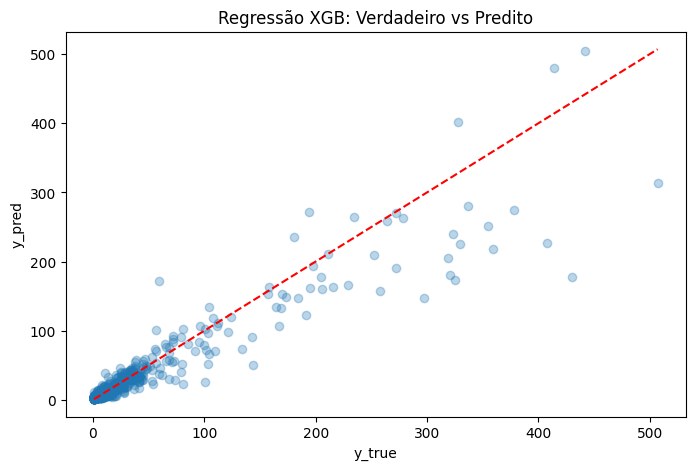

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Melhor RF reg params: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Validação (reg RF) → RMSE: 12.043 | MAE: 4.717
Teste (reg RF) → RMSE: 16.709 | MAE: 5.587


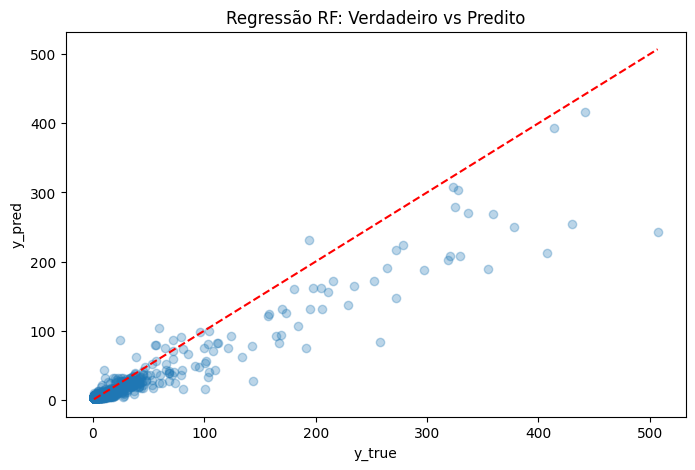

['model_reg_rf.pkl']

In [ ]:
# -*- coding: utf-8 -*-
# ===== Treinamento: dois modelos para regressão + dois para classificação =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, f1_score, precision_score, recall_score, RocCurveDisplay
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import joblib

# ---- caminhos para os dados ----
PATH_FEATS = Path(DIRS["processed"]) / "dataset_municipio_semana_feats.parquet"

# ---- carregamento ----
df = pd.read_parquet(PATH_FEATS).copy()
df = df.sort_values(["YEAR_ISO", "SE", "cod_mun"])  # garante ordenação temporal

# ---- criar variável de surto (exemplo: limiar no inc100k) ----
limiar = df["inc100k"].quantile(0.90)
df["target_surto"] = (df["inc100k"] >= limiar).astype(int)

# ---- remover colunas que não servem como feature (identificadores) ----
if "cod_mun_6" in df.columns:
    df = df.drop(columns=["cod_mun_6"])
if "cod_mun" in df.columns:
    # se quiser, pode manter cod_mun como categoria ou remover
    df = df.drop(columns=["cod_mun"])

# ---- definir colunas e alvos ----
FEATURE_COLS = [c for c in df.columns if c not in ["SE", "YEAR_ISO", "y_tplus1", "target_surto"]]

TARGET_REG = "y_tplus1"
TARGET_CLS = "target_surto"

# ---- verificar que todas as features são numéricas ou booleanas ----
print("Dtypes das features:")
print(df[FEATURE_COLS].dtypes.value_counts())
assert all(df[FEATURE_COLS].dtypes.apply(lambda x: x.kind in ("i","u","f","b"))), \
       "Algumas colunas de FEATURE_COLS não são numéricas/booleanas!"

# ---- dividir 90% treino / 5% validação / 5% teste ----
n = len(df)
idx_train_end = int(n * 0.90)
idx_valid_end = int(n * 0.95)

df_train = df.iloc[:idx_train_end]
df_valid = df.iloc[idx_train_end:idx_valid_end]
df_test  = df.iloc[idx_valid_end:]

X_train = df_train[FEATURE_COLS]
y_train_reg = df_train[TARGET_REG]
y_train_cls = df_train[TARGET_CLS]

X_valid = df_valid[FEATURE_COLS]
y_valid_reg = df_valid[TARGET_REG]
y_valid_cls = df_valid[TARGET_CLS]

X_test = df_test[FEATURE_COLS]
y_test_reg = df_test[TARGET_REG]
y_test_cls = df_test[TARGET_CLS]

print("Shapes → treino:", X_train.shape, "validação:", X_valid.shape, "teste:", X_test.shape)

# ---- parâmetros para modelos ----

params_reg_xgb = {
    "max_depth": [3,5],
    "learning_rate": [0.1,0.01],
    "subsample": [0.8,1.0],
    "colsample_bytree": [0.8,1.0]
}
params_reg_rf = {
    "n_estimators": [100,200],
    "max_depth": [5,10],
    "max_features": ["sqrt","log2"]
}
params_cls_xgb = {
    "max_depth": [3,5],
    "learning_rate": [0.1,0.01],
    "subsample": [0.8,1.0],
    "colsample_bytree": [0.8,1.0]
}
params_cls_rf = {
    "n_estimators": [100,200],
    "max_depth": [5,10],
    "max_features": ["sqrt","log2"]
}

# ---- TREINO REGRESSÃO → XGBoost ----
# Usando regressão de Poisson, que é mais apropriada para problemas de contagem.
reg_xgb = XGBRegressor(objective="count:poisson", eval_metric="rmse", random_state=42, n_jobs=-1)
grid_reg_xgb = GridSearchCV(reg_xgb, params_reg_xgb, cv=5, scoring="neg_mean_squared_error", verbose=1)
grid_reg_xgb.fit(X_train, y_train_reg)
best_reg_xgb = grid_reg_xgb.best_estimator_
print("Melhor XGBoost reg params:", grid_reg_xgb.best_params_)

# avaliação validação
y_valid_pred_xgb = best_reg_xgb.predict(X_valid)
rmse_val_xgb = np.sqrt(mean_squared_error(y_valid_reg, y_valid_pred_xgb))
mae_val_xgb  = mean_absolute_error(y_valid_reg, y_valid_pred_xgb)
print(f"Validação (reg XGB) → RMSE: {rmse_val_xgb:.3f} | MAE: {mae_val_xgb:.3f}")

# avaliação teste
y_test_pred_xgb = best_reg_xgb.predict(X_test)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_xgb))
mae_test_xgb  = mean_absolute_error(y_test_reg, y_test_pred_xgb)
print(f"Teste (reg XGB) → RMSE: {rmse_test_xgb:.3f} | MAE: {mae_test_xgb:.3f}")

plt.figure(figsize=(8,5))
plt.scatter(y_test_reg, y_test_pred_xgb, alpha=0.3)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("Regressão XGB: Verdadeiro vs Predito")
plt.show()
joblib.dump(best_reg_xgb, "model_reg_xgb.pkl")

# ---- TREINO REGRESSÃO → RandomForest ----
reg_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_reg_rf = GridSearchCV(reg_rf, params_reg_rf, cv=5, scoring="neg_mean_squared_error", verbose=1)
grid_reg_rf.fit(X_train, y_train_reg)
best_reg_rf = grid_reg_rf.best_estimator_
print("Melhor RF reg params:", grid_reg_rf.best_params_)

y_valid_pred_rf = best_reg_rf.predict(X_valid)
rmse_val_rf = np.sqrt(mean_squared_error(y_valid_reg, y_valid_pred_rf))
mae_val_rf  = mean_absolute_error(y_valid_reg, y_valid_pred_rf)
print(f"Validação (reg RF) → RMSE: {rmse_val_rf:.3f} | MAE: {mae_val_rf:.3f}")

y_test_pred_rf = best_reg_rf.predict(X_test)
rmse_test_rf = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_rf))
mae_test_rf  = mean_absolute_error(y_test_reg, y_test_pred_rf)
print(f"Teste (reg RF) → RMSE: {rmse_test_rf:.3f} | MAE: {mae_test_rf:.3f}")

plt.figure(figsize=(8,5))
plt.scatter(y_test_reg, y_test_pred_rf, alpha=0.3)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("Regressão RF: Verdadeiro vs Predito")
plt.show()
joblib.dump(best_reg_rf, "model_reg_rf.pkl")

###Gráfico de resíduos
O gráfico nos mostra se o modelo subestima ou superestima o número de casos. Ambos os cenários são ruins: em um, os órgãos de saúde gastam dinheiro se preparando para um número de casos maior que o real. No outro, o sistema não se prepara adequadamente, e a saúde pública fica em risco.

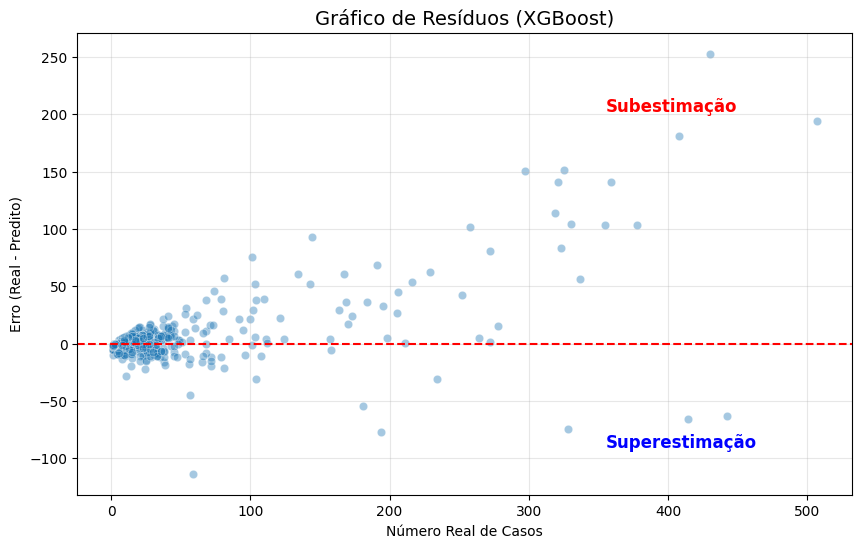

Viés Médio do Modelo: 1.00 (subestima)


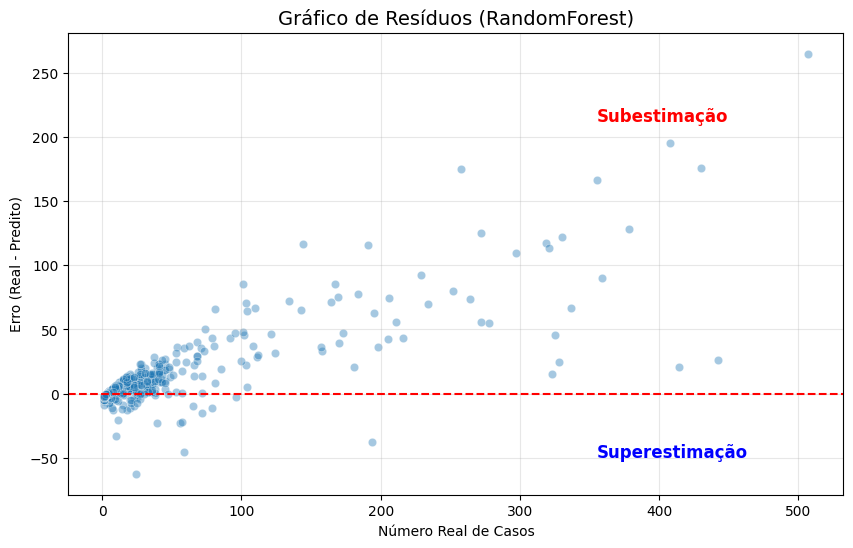

Viés Médio do Modelo: 2.45 (subestima)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for y_test_pred, modelo in [(y_test_pred_xgb, "XGBoost"), (y_test_pred_rf, "RandomForest")]:
  # Calcula os resíduos
  residuos = y_test_reg - y_test_pred # (Real - Predito)

  plt.figure(figsize=(10, 6))

  # Plota os resíduos
  sns.scatterplot(x=y_test_reg, y=residuos, alpha=0.4)

  # Linha de referência (Erro Zero)
  plt.axhline(0, color='red', linestyle='--')

  plt.title(f"Gráfico de Resíduos ({modelo})", fontsize=14)
  plt.xlabel("Número Real de Casos")
  plt.ylabel("Erro (Real - Predito)")

  # Regiões de Interpretação
  plt.text(x=y_test_reg.max()*0.7, y=residuos.max()*0.8, s="Subestimação", color='red', fontsize=12, fontweight='bold')
  plt.text(x=y_test_reg.max()*0.7, y=residuos.min()*0.8, s="Superestimação", color='blue', fontsize=12, fontweight='bold')

  plt.grid(True, alpha=0.3)
  plt.show()

  # Métrica de Viés (Bias)
  bias = residuos.mean()
  vies = "subestima"
  if bias < 0:
      vies = "superestima"
  print(f"Viés Médio do Modelo: {bias:.2f} ({vies})")

Total Amostras: 36599
Treino + Validação: 29279 | Teste Final: 7320
Distribuição de Classes no Teste: {0: 2727, 1: 1355, 2: 1000, 3: 2238}
XGBoost Média F1: 0.7219 (+/- 0.0163)
RandomF Média F1: 0.7130 (+/- 0.0159)

>>> 3.6 Resultados Finais no Conjunto de Teste (XGBoost)
              precision    recall  f1-score   support

   Verde (0)       0.85      0.91      0.88      2727
 Amarelo (1)       0.58      0.56      0.57      1355
 Laranja (2)       0.57      0.45      0.50      1000
Vermelho (3)       0.86      0.88      0.87      2238

    accuracy                           0.77      7320
   macro avg       0.72      0.70      0.71      7320
weighted avg       0.76      0.77      0.77      7320



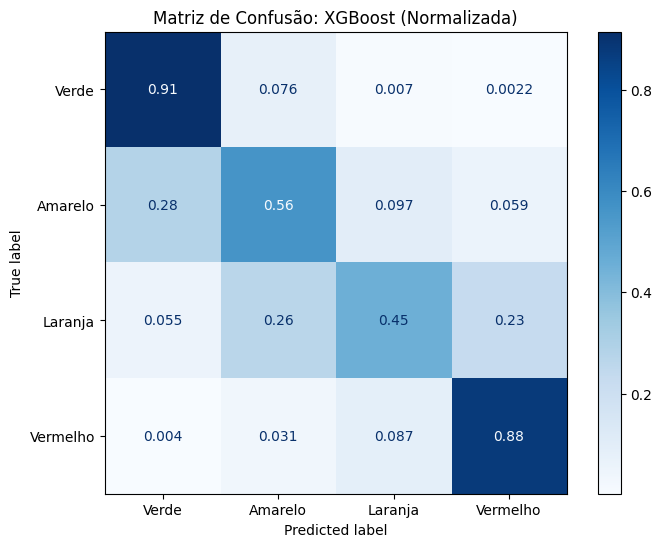

Modelo de Classificação salvo como 'model_cls_final.pkl'


In [ ]:
# -*- coding: utf-8 -*-
# ===== 3. CLASSIFICAÇÃO =====
# Alvo: Níveis de Alerta (0=Verde, 1=Amarelo, 2=Laranja, 3=Vermelho)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Critérios de Incidência (Casos por 100k hab)
def classificar_risco(incidencia):
    if incidencia < 20: return 0   # Verde (Baixo)
    elif incidencia < 50: return 1 # Amarelo (Atenção)
    elif incidencia < 100: return 2 # Laranja (Alerta)
    return 3                        # Vermelho (Emergência)

df = pd.read_parquet(PATH_FEATS).copy()

# Recria a lista de features numéricas segura (caso não esteja na memória)
import numpy as np
df_numeric = df.select_dtypes(include=[np.number])
ignore_cols = ["y_tplus1", "inc100k_tplus1", "target_surto_tplus1", "SE", "cod_mun", "YEAR_ISO", "target_surto"]
REAL_FEATURES = [c for c in df_numeric.columns if c not in ignore_cols and "tplus1" not in c]

# Calcular Incidência Futura (t+1) para criar o alvo
# (Garantimos a ordenação para o shift funcionar corretamente)
df = df.sort_values(["cod_mun", "SE"])
df['inc100k_tplus1'] = df.groupby("cod_mun")['inc100k'].shift(-1)

# Criar o alvo categórico
df['target_nivel'] = df['inc100k_tplus1'].apply(classificar_risco)

# Remover dados da última semana (que não têm "futuro" conhecido para treino)
df_classif = df.dropna(subset=['inc100k_tplus1']).copy()

# 80% para Treino/Validação | 20% para Teste
split_idx = int(len(df_classif) * 0.80)

X = df_classif[REAL_FEATURES] # Usa a lista segura de features numéricas
y = df_classif['target_nivel']

X_train_full, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_full, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Total Amostras: {len(df_classif)}")
print(f"Treino + Validação: {len(X_train_full)} | Teste Final: {len(X_test)}")
print(f"Distribuição de Classes no Teste: {y_test.value_counts().sort_index().to_dict()}")

# XGBoost
# objective='multi:softprob' é essencial para classificação multiclasse
clf_xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Random Forest
# class_weight='balanced' ajuda se tivermos poucos casos de 'Vermelho'
clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# ---- 3.4 VALIDAÇÃO CRUZADA TEMPORAL (TimeSeriesSplit) ----
tscv = TimeSeriesSplit(n_splits=5)

# Métrica: F1-Weighted (Média ponderada do acerto entre as classes)
# Usamos weighted porque as classes são desbalanceadas (muito mais Verde que Vermelho)
scores_xgb = cross_val_score(clf_xgb, X_train_full, y_train_full, cv=tscv, scoring='f1_weighted')
scores_rf = cross_val_score(clf_rf, X_train_full, y_train_full, cv=tscv, scoring='f1_weighted')

print(f"XGBoost Média F1: {scores_xgb.mean():.4f} (+/- {scores_xgb.std():.4f})")
print(f"RandomF Média F1: {scores_rf.mean():.4f} (+/- {scores_rf.std():.4f})")

# ---- 3.5 SELEÇÃO E TREINO FINAL ----
if scores_xgb.mean() >= scores_rf.mean():
    best_model = clf_xgb
    model_name = "XGBoost"
else:
    best_model = clf_rf
    model_name = "Random Forest"

best_model.fit(X_train_full, y_train_full)

# ---- 3.6 AVALIAÇÃO NO TESTE FINAL (O FUTURO) ----
print(f"\n>>> 3.6 Resultados Finais no Conjunto de Teste ({model_name})")
y_pred = best_model.predict(X_test)

# Relatório Numérico
print(classification_report(y_test, y_pred, target_names=['Verde (0)', 'Amarelo (1)', 'Laranja (2)', 'Vermelho (3)']))

# Matriz de Confusão Visual
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['Verde', 'Amarelo', 'Laranja', 'Vermelho'],
    cmap='Blues',
    normalize='true', # Mostra porcentagem (bom para classes desbalanceadas)
    ax=ax
)
ax.set_title(f"Matriz de Confusão: {model_name} (Normalizada)")
plt.show()

import joblib
joblib.dump(best_model, "model_cls_final.pkl")
print("Modelo de Classificação salvo como 'model_cls_final.pkl'")

In [ ]:
clf_multi = best_model

In [ ]:
import joblib
import shutil
import os


pasta_drive = '/content/drive/MyDrive/modelos_salvos'


for model_name in ["model_reg_xgb.pkl", "model_reg_rf.pkl"]:
    if os.path.exists(model_name):
        shutil.copy(model_name, f"{pasta_drive}/{model_name}")
        print(f"Regressão salvo: {model_name}")
    else:
        print(f"{model_name} não encontrado.")


if os.path.exists("model_cls_final.pkl"):
    shutil.copy("model_cls_final.pkl", f"{pasta_drive}/model_cls_final.pkl")
    print(f"Classificação salvo: model_cls_final.pkl")
else:
    print("'model_cls_final.pkl' não encontrado.")

print("\nBackup concluído.")

Regressão salvo: model_reg_xgb.pkl
Regressão salvo: model_reg_rf.pkl
Classificação salvo: model_cls_final.pkl

Backup concluído.


In [ ]:
import joblib


caminho_modelo = '/content/drive/MyDrive/modelos_salvos/model_reg_xgb.pkl'

print("Carregando modelo treinado...")
model = joblib.load(caminho_modelo)
print("Modelo carregado e pronto para usar!")

Carregando modelo treinado...
Modelo carregado e pronto para usar!


*O* conjunto de testes não tem nenhum surto, pois o período de abrangência caiu justamente na época de baixa da doença, que é sazonal.

Período total de análise: 202401 a 202541
Total de Surtos identificados na base toda: 3725


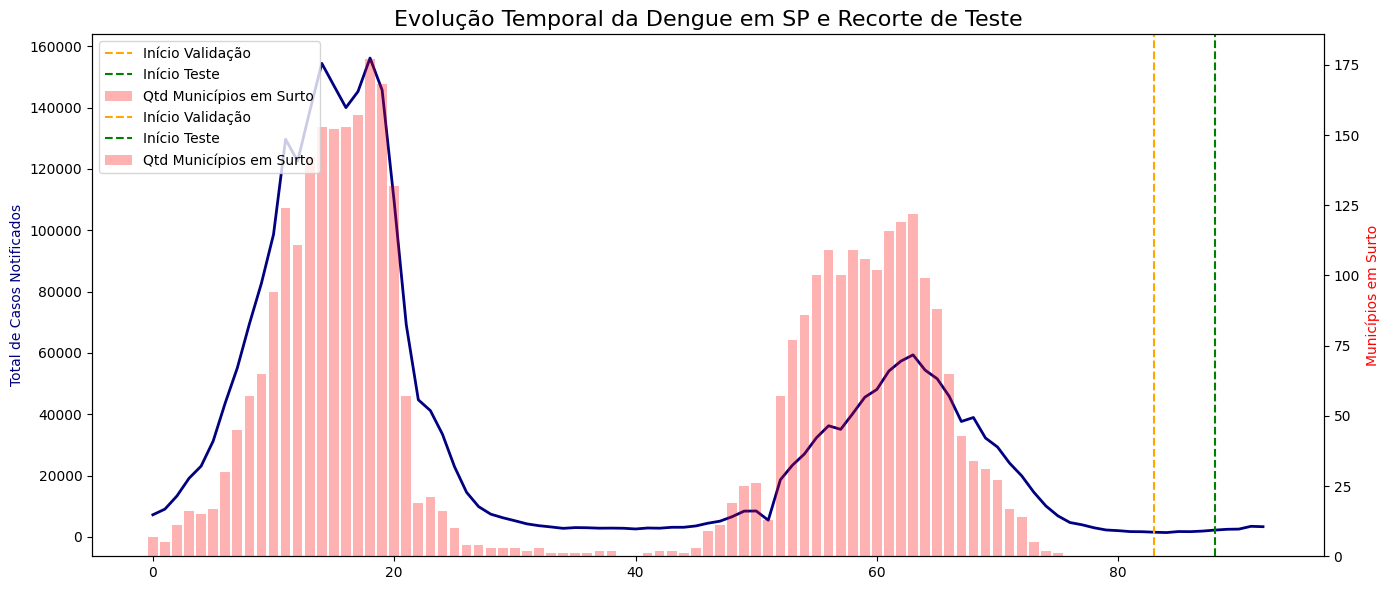

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. GARANTIR QUE A COLUNA EXISTE
if "target_surto" not in df.columns:
    # Recria a lógica de surto (Top 10% de incidência)
    limiar = df["inc100k"].quantile(0.90)
    df["target_surto"] = (df["inc100k"] >= limiar).astype(int)

# 2. DIAGNÓSTICO (Reimprime para confirmar)
print(f"Período total de análise: {df['SE'].min()} a {df['SE'].max()}")
print(f"Total de Surtos identificados na base toda: {df['target_surto'].sum()}")

# 3. VISUALIZAÇÃO DE TENDÊNCIA TEMPORAL
# Agrupa por semana para ver a curva do estado
df_temporal = df.groupby("SE")[["casos_obs", "target_surto"]].sum().reset_index()
df_temporal["time_idx"] = range(len(df_temporal))

plt.figure(figsize=(14, 6))

# Plota a linha de casos (Eixo da Esquerda)
plt.plot(df_temporal["time_idx"], df_temporal["casos_obs"], color='navy', linewidth=2, label="Total de Casos")
plt.ylabel("Total de Casos Notificados", color='navy')

# Plota a "frequência de surtos" (Eixo da Direita - Opcional, mas legal)
ax2 = plt.gca().twinx()
ax2.bar(df_temporal["time_idx"], df_temporal["target_surto"], color='red', alpha=0.3, label="Qtd Municípios em Surto")
ax2.set_ylabel("Municípios em Surto", color='red')

# Linhas de corte do tempo
n = len(df_temporal)
split_valid = int(n * 0.90)
split_test = int(n * 0.95)

plt.axvline(split_valid, color='orange', linestyle='--', label='Início Validação')
plt.axvline(split_test, color='green', linestyle='--', label='Início Teste')

plt.title("Evolução Temporal da Dengue em SP e Recorte de Teste", fontsize=16)
plt.xlabel("Semanas (Sequencial)")

# Legenda combinada
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()


## Inferência e mapa

**Inferência:**

* Constroi-se o *feature set* da **semana t** com os dados históricos até t (casos e clima) e é gerado `ŷ_{t+1}` por município.
* Converta para **incidência/100k** com `pop` IBGE 2025. ([IBGE][6])

**Mapa (IBGE malha municipal):**

* Lemos a malha municipal de SP (shape) — campo **`CD_MUN` (7 dígitos)**. Faça *join* com `cod_mun_ibge_7d`. ([IBGE][7])
* Plote **coroplético** de `inc100k_pred_{t+1}` (quantis/“natural breaks”), legenda, barra de cores e *hover* com município, casos previstos e incidência.
* Exporta-se PNG/HTML (folium/Plotly) e um CSV com `[cod_mun, nome, ŷ, inc100k_pred]`.

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
from pathlib import Path
import joblib

# ---- caminhos ----
PATH_FEATS   = Path(DIRS["processed"]) / "dataset_municipio_semana_feats.parquet"
MODEL_PATH   = "model_reg_xgb.pkl"  # ou outro modelo salvo
PATH_OUTPUT  = Path(DIRS["processed"]) / "predicoes_municipio_semana.parquet"

# ---- carregamento dados e modelo ----
df = pd.read_parquet(PATH_FEATS).copy()
model = joblib.load(MODEL_PATH)

# ---- preparar dados de predição ----
# suponha que você queira prever para a última semana disponível no df
ultima_SE = df["SE"].max()
df_last   = df[df["SE"] == ultima_SE].copy()

FEATURE_COLS = [c for c in df_last.columns
                if c not in ["cod_mun","SE","YEAR_ISO","y_tplus1","target_surto"]
                and df_last[c].dtype in [float, int]]

X_last = df_last[FEATURE_COLS]

# Ordena para garantir que o tempo (SE) esteja sequencial
df_last = df_last.sort_values(["cod_mun", "SE"])

# Preenche os NaNs usando o valor anterior (ffill) DENTRO de cada grupo de município
# O método transform garante que o índice original seja preservado
cols_to_fill = [c for c in FEATURE_COLS if c in df_last.columns]

# Aplica o ffill apenas nas colunas de features
for col in cols_to_fill:
    df_last[col] = df_last.groupby("cod_mun")[col].ffill()

# Se ainda sobrar NaN (caso o primeiro registro do município já seja NaN), preenche com 0
df_last = df_last.fillna(0)
# ---- fazer predição ----
df_last["y_predito"] = model.predict(X_last)

# Estatísticas da predição
print(df_last["y_predito"].describe())

# Verifique se existem valores maiores que 1
print(f"Cidades com previsão > 1 caso: {(df_last['y_predito'] > 1).sum()}")

# Veja os maiores valores previstos
print(df_last.sort_values("y_predito", ascending=False)[["cod_mun", "y_predito"]].head(5))

# ---- salvar previsões ----
df_last[["cod_mun","SE","y_predito"]].to_parquet(PATH_OUTPUT, index=False)
print(f"Predições salvas em {PATH_OUTPUT}, para SE {ultima_SE}, {len(df_last)} municípios.")


count    179.000000
mean      19.934065
std       55.601562
min        2.006824
25%        2.851425
50%        4.344092
75%       10.731510
max      479.530365
Name: y_predito, dtype: float64
Cidades com previsão > 1 caso: 179
       cod_mun   y_predito
6212   3509502  479.530365
31947  3549805  402.461945
28067  3543402  271.072540
32040  3549904  177.907791
32315  3550308  173.818054
Predições salvas em /content/dados/Trabalho_Ia/data/processed/predicoes_municipio_semana.parquet, para SE 202541, 179 municípios.


In [ ]:
print("Última SE disponível:", ultima_SE)
print("Features usadas para predição (amostra):")
print(df_last[FEATURE_COLS].head(3))
print("Tem algum NaN?", df_last[FEATURE_COLS].isna().sum().sum())

Última SE disponível: 202541
Features usadas para predição (amostra):
      casos_obs    tmean_c   tdmean_c    rh_mean  rain_sum_mm  rain_days  \
80            7  25.475143  15.895552  56.849031          0.0        0.0   
290           3  22.149948  13.986159  61.313900          0.0        0.0   
1032          6  22.686487  14.614414  62.013872          0.0        0.0   

           pop    inc100k  casos_obs_lag1  tmean_c_lag1  ...  \
80     35673.0  19.622684             3.0     27.507346  ...   
290    18257.0  16.432053             5.0     23.612513  ...   
1032  247571.0   2.423547             8.0     24.825152  ...   

      rain_sum_mm_lag8  rain_days_lag8  casos_obs_mm2  casos_obs_mm4  \
80            0.201988             0.0            5.0            3.5   
290          47.717096             2.0            4.0            3.0   
1032          0.000000             0.0            7.0            5.0   

      casos_obs_mm8    sin_w     cos_w  weekofyear  year_iso  inc100k_tplus1  


In [ ]:
# Instalando dependências
!pip install mapclassify

Ao tentar usar a semana epidemiológica mais recente para prever o número de casos da próxima, surge um problema: muitas cidades não têm os dados atualizados, o que leva a uma previsão de 0 casos para estes municípios. Ao plotar o gráfico, nada aparece.

/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self.bins = quantile(y, k=k)


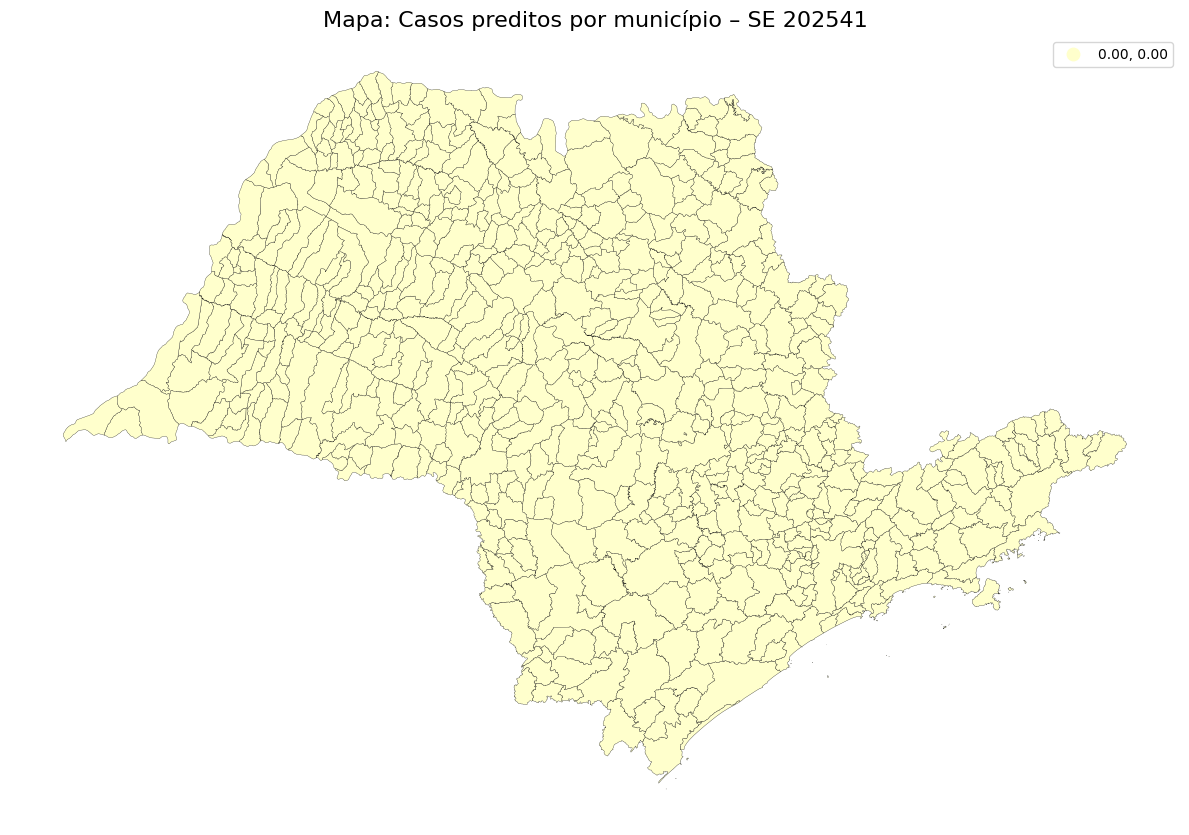

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from geobr import read_municipality

# ---- caminhos ----
PATH_PRED = Path(DIRS["processed"]) / "predicoes_municipio_semana.parquet"

# ---- carregar predições e malha municipal de SP ----
df_pred = pd.read_parquet(PATH_PRED)
df_pred["cod_mun"] = df_pred["cod_mun"].astype(str).str.zfill(7)

gdf_sp = read_municipality(code_muni="SP", year=2020)[["code_muni","geometry"]]
gdf_sp = gdf_sp.rename(columns={"code_muni":"cod_mun"})
gdf_sp["cod_mun"] = gdf_sp["cod_mun"].astype(str).str.zfill(7)
gdf_sp = gdf_sp.to_crs(epsg=4326)

# ---- merge entre geometria + predição ----
gdf_map = gdf_sp.merge(df_pred, on="cod_mun", how="left")
gdf_map["y_predito"] = gdf_map["y_predito"].fillna(0)

# ---- plotagem ----
fig, ax = plt.subplots(1, 1, figsize=(12,10))
# Faz o plot
gdf_map.plot(column="y_predito",
             ax=ax,
             cmap="YlOrRd",
             scheme="quantiles",
             legend=True,
             edgecolor="black",
             linewidth=0.2)

# Ajustar título e remover eixos
ultima_SE = int(df_pred["SE"].max())
ax.set_title(f"Mapa: Casos preditos por município – SE {ultima_SE}", fontsize=16)
ax.set_axis_off()

# Ajustar rótulo da barra de cores (colorbar)
cbar = ax.get_figure().axes[-1]
cbar.set_ylabel("Casos preditos (última semana)", rotation=90, fontsize=12)

plt.tight_layout()
plt.show()


Como alternativa, vamos usar a semana epidemiológica com dados mais recente de cada cidade.

Selecionando o dado mais recente de cada município...
Gerando previsões para 645 municípios...


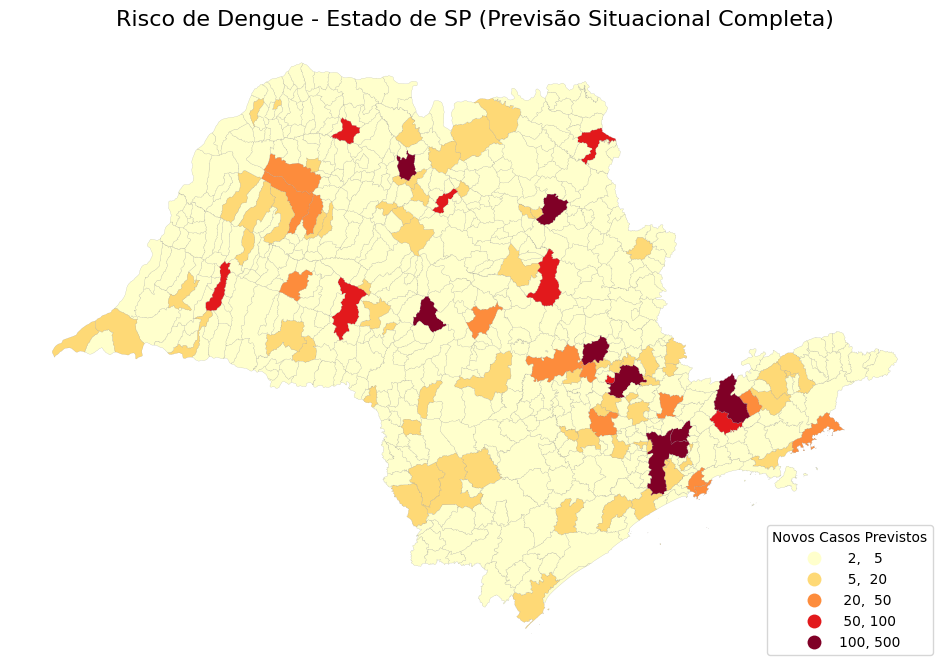

In [ ]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from geobr import read_municipality

# 1. Carregar dados e modelo
# Certifique-se que PATH_FEATS e MODEL_PATH estão definidos anteriormente
df = pd.read_parquet(PATH_FEATS).copy()
# Se o modelo não estiver na memória, carregue-o:
# model = joblib.load("model_reg_xgb.pkl")

# 2. A ESTRATÉGIA: Pegar o último dado disponível de CADA cidade
print("Selecionando o dado mais recente de cada município...")
df_full = df.sort_values(["cod_mun", "SE"]).groupby("cod_mun").tail(1).copy()

# 3. Tratamento de Nulos (Garantia para não quebrar)
# Lista de features numéricas usadas no treino
cols_to_fill = [c for c in df_full.columns if c not in ["cod_mun", "SE", "YEAR_ISO", "target_surto"] and df_full[c].dtype in ['float64', 'int64']]
df_full[cols_to_fill] = df_full[cols_to_fill].ffill().fillna(0)

# 4. Fazer a Predição
print(f"Gerando previsões para {len(df_full)} municípios...")
# Garante que usamos apenas as colunas que o modelo conhece
feats_model = model.feature_names_in_
df_full["y_predito"] = model.predict(df_full[feats_model])

# 5. Limpeza Visual (Remove negativos)
df_full["y_predito"] = df_full["y_predito"].clip(lower=0)

# --- PREPARAÇÃO E PLOTAGEM DO MAPA ---
# Carregar mapa
gdf_sp = read_municipality(code_muni="SP", year=2020)
gdf_sp = gdf_sp.to_crs(epsg=4326)

# Padronizar códigos para o merge perfeito
gdf_sp["cod_mun_join"] = gdf_sp["code_muni"].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(7)
df_full["cod_mun_join"] = df_full["cod_mun"].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(7)

# Merge
gdf_map_full = gdf_sp.merge(df_full, on="cod_mun_join", how="left")
gdf_map_full["y_predito"] = gdf_map_full["y_predito"].fillna(0)

# Plotagem com Faixas Manuais (Para ficar bonito e legível)
faixas = [5, 20, 50, 100, 500]

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gdf_map_full.plot(
    column="y_predito",
    ax=ax,
    cmap="YlOrRd",
    scheme="UserDefined",
    classification_kwds={'bins': faixas},
    legend=True,
    legend_kwds={'title': 'Novos Casos Previstos', 'fmt': '{:.0f}', 'loc': 'lower right'},
    edgecolor='gray',
    linewidth=0.1
)

ax.set_title("Risco de Dengue - Estado de SP (Previsão Situacional Completa)", fontsize=16)
ax.set_axis_off()
plt.show()

### Real vs Predição
O gráfico abaixo mostra a relação entre o número real de casos e o predito pelo modelo para a cidade de Sâo Paulo.
As duas curvas continuam próximas mesmo após o início dos testes, o que mostra que o modelo é capaz de generalizar o que aprendeu.

Analisando dados para: São Paulo (Capital) (Cod: 3550308)


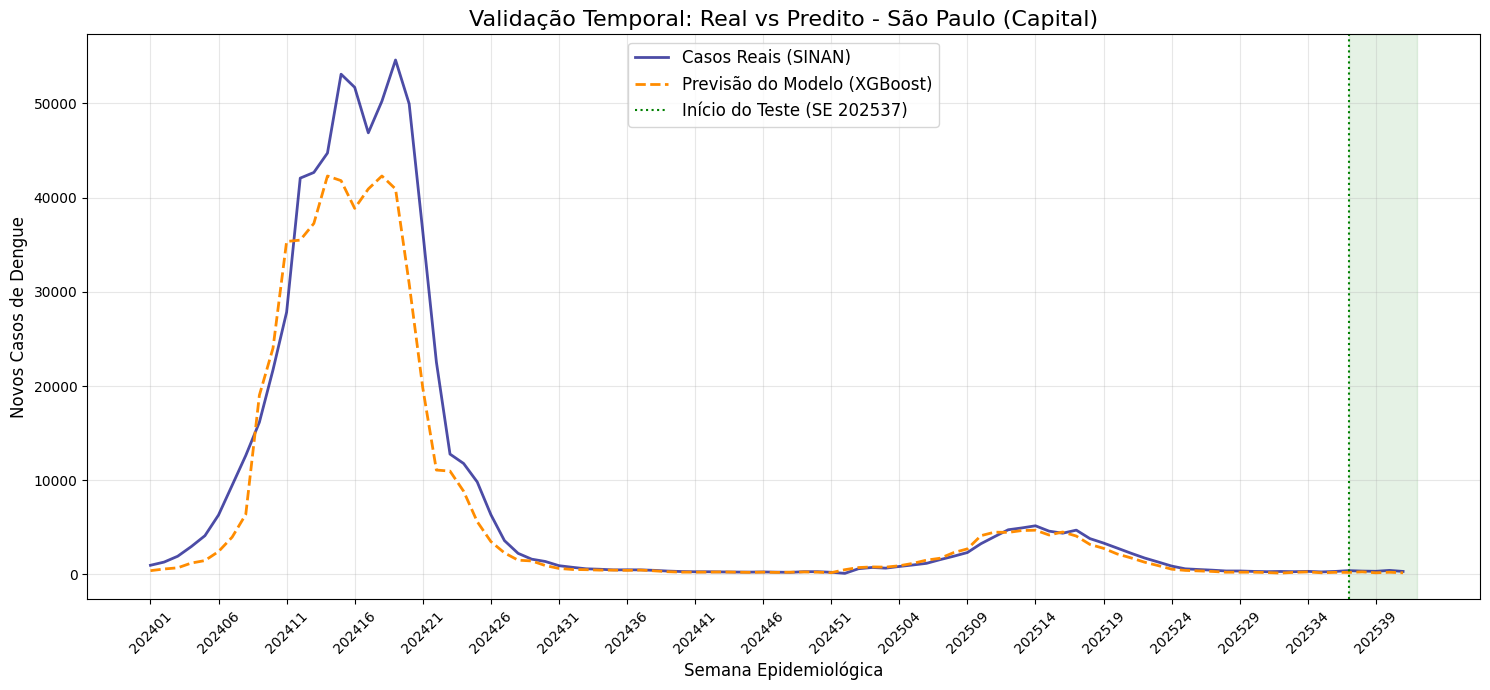

Erro Médio Absoluto (MAE) para SP: 1888.3 casos por semana


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import joblib

# 1. CONFIGURAÇÃO
cidade_alvo = "3550308"  # Código de São Paulo (Capital)
nome_cidade = "São Paulo (Capital)"

# Carregar dados e modelo (caso precise recarregar)
# df = pd.read_parquet(PATH_FEATS).copy()
# model = joblib.load("model_reg_xgb.pkl")

# 2. FILTRAR DADOS DA CIDADE
print(f"Analisando dados para: {nome_cidade} (Cod: {cidade_alvo})")
df_sp = df[df["cod_mun"] == cidade_alvo].sort_values("SE").copy()

# 3. PREPARAR FEATURES E PREDIZER
# Garantir que não tem NaNs nas features (mesma lógica do mapa)
cols_to_fill = [c for c in FEATURE_COLS if c in df_sp.columns]
df_sp[cols_to_fill] = df_sp[cols_to_fill].ffill().fillna(0)

# Predição para toda a série temporal
X_sp = df_sp[FEATURE_COLS]
df_sp["y_predito_full"] = model.predict(X_sp)

# Ajuste estético (sem negativos)
df_sp["y_predito_full"] = df_sp["y_predito_full"].clip(lower=0)

# 4. PLOTAGEM (REAL vs PREDITO)
plt.figure(figsize=(15, 7))

# Eixo X: Vamos criar um índice sequencial para ficar mais legível que "202401, 202402..."
x_axis = range(len(df_sp))
semanas_labels = df_sp["SE"].astype(str).values

# Linha 1: Real (Observado)
plt.plot(x_axis, df_sp["casos_obs"], label="Casos Reais (SINAN)", color='navy', linewidth=2, alpha=0.7)

# Linha 2: Predito (Modelo)
plt.plot(x_axis, df_sp["y_predito_full"], label="Previsão do Modelo (XGBoost)", color='darkorange', linestyle='--', linewidth=2)

# Marcar onde começa o "Futuro" (Teste)
# Assumindo os últimos 5% como teste (igual ao treino do modelo)
split_idx = int(len(df_sp) * 0.95)
semana_corte = df_sp.iloc[split_idx]["SE"]

plt.axvline(split_idx, color='green', linestyle=':', label=f'Início do Teste (SE {semana_corte})')
plt.axvspan(split_idx, len(df_sp), color='green', alpha=0.1) # Sombra verde na área de teste

# Formatação
plt.title(f"Validação Temporal: Real vs Predito - {nome_cidade}", fontsize=16)
plt.xlabel("Semana Epidemiológica", fontsize=12)
plt.ylabel("Novos Casos de Dengue", fontsize=12)
plt.xticks(x_axis[::5], semanas_labels[::5], rotation=45) # Mostra 1 rótulo a cada 5 semanas
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Diagnóstico de Erro Local
from sklearn.metrics import mean_absolute_error
erro_sp = mean_absolute_error(df_sp["casos_obs"], df_sp["y_predito_full"])
print(f"Erro Médio Absoluto (MAE) para SP: {erro_sp:.1f} casos por semana")

Gerando cenário de risco para todo o estado...


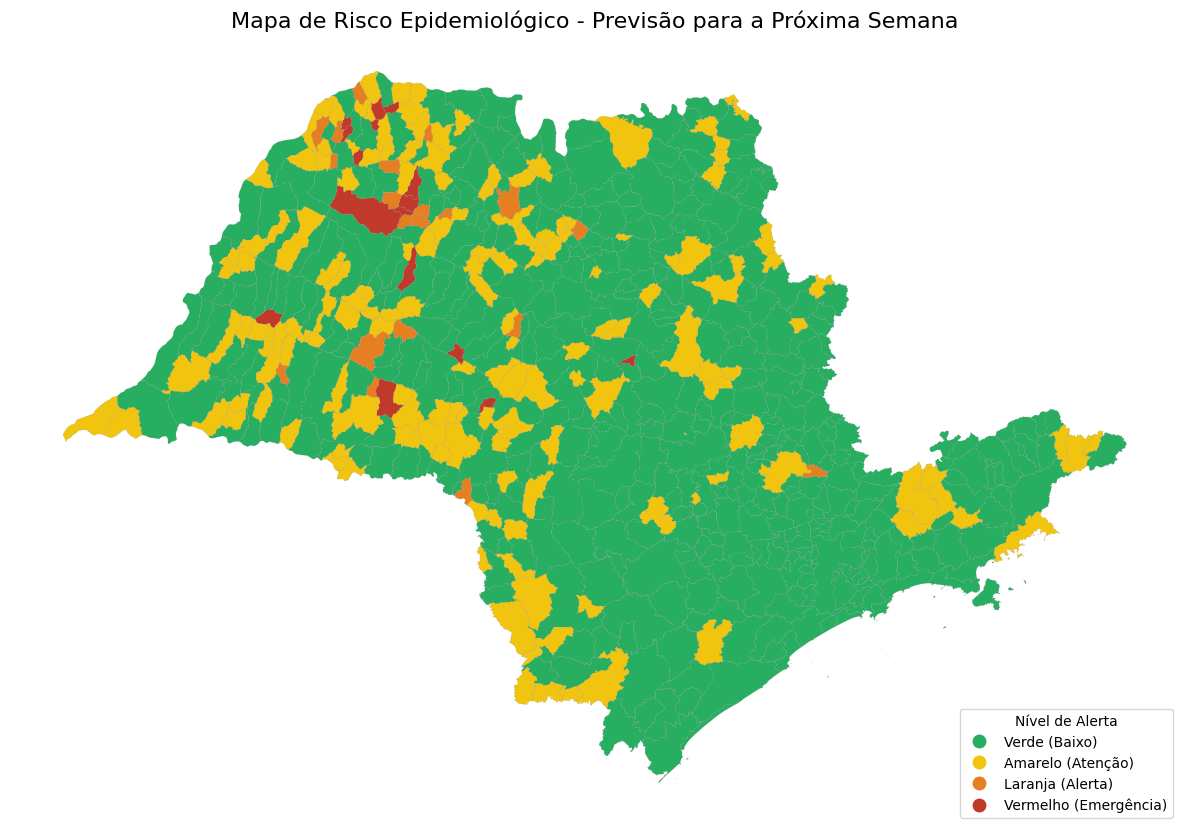

Contagem de Cidades por Nível de Risco Previsto:
Verde: 441 cidades
Amarelo: 168 cidades
Laranja: 20 cidades
Vermelho: 16 cidades


In [ ]:
# --- 4. MAPA DE RISCO (CLASSIFICAÇÃO SITUACIONAL) ---
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from geobr import read_municipality

# 1. PREPARAR DADOS DA ÚLTIMA SEMANA
print("Gerando cenário de risco para todo o estado...")
  # Pega o último registro histórico de cada município
df_hoje = df.sort_values(["cod_mun", "SE"]).groupby("cod_mun").tail(1).copy()

# Preenche nulos nas features
# Usa a lista REAL_FEATURES para garantir que só tem colunas numéricas
cols_to_fill = [c for c in REAL_FEATURES if c in df_hoje.columns]
df_hoje[cols_to_fill] = df_hoje[cols_to_fill].ffill().fillna(0)

# 2. PREDIÇÃO DO NÍVEL
df_hoje['nivel_predito'] = clf_multi.predict(df_hoje[REAL_FEATURES])

# 3. PREPARAR O MAPA
gdf_sp = read_municipality(code_muni="SP", year=2020)
gdf_sp = gdf_sp.to_crs(epsg=4326)

# Padronizar códigos do IBGE para o merge
gdf_sp["cod_mun_join"] = gdf_sp["code_muni"].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(7)
df_hoje["cod_mun_join"] = df_hoje["cod_mun"].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(7)

# Merge dos dados com o desenho do mapa
gdf_map_risk = gdf_sp.merge(df_hoje, on="cod_mun_join", how="left")

# Cidades sem dados viram "Verde" (0) por padrão (ou crie uma classe -1 para "Sem Dados")
gdf_map_risk["nivel_predito"] = gdf_map_risk["nivel_predito"].fillna(0).astype(int)

# 4. DEFINIR AS CORES DO SEMÁFORO
# 0=Verde, 1=Amarelo, 2=Laranja, 3=Vermelho
cores_semaforo = ['#27ae60', '#f1c40f', '#e67e22', '#c0392b']
cmap_risk = ListedColormap(cores_semaforo)

# 5. PLOTAGEM FINAL
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gdf_map_risk.plot(
    column="nivel_predito",
    ax=ax,
    cmap=cmap_risk,
    categorical=True,    # Importante para tratar como categorias fixas
    legend=True,
    legend_kwds={
        'title': 'Nível de Alerta',
        'loc': 'lower right',
        'labels': ['Verde (Baixo)', 'Amarelo (Atenção)', 'Laranja (Alerta)', 'Vermelho (Emergência)']
    },
    edgecolor='gray',
    linewidth=0.1
)

ax.set_title("Mapa de Risco Epidemiológico - Previsão para a Próxima Semana", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Diagnóstico Rápido
print("Contagem de Cidades por Nível de Risco Previsto:")
contagem = df_hoje['nivel_predito'].value_counts().sort_index()
niveis = {0: 'Verde', 1: 'Amarelo', 2: 'Laranja', 3: 'Vermelho'}
for nivel, count in contagem.items():
    print(f"{niveis.get(nivel, nivel)}: {count} cidades")

In [ ]:
# Salvando as predições no Drive
# Exemplo para salvar no Drive
!cp /content/dados/Trabalho_Ia/data/processed/predicoes_municipio_semana.parquet /content/drive/MyDrive/